# 0. Import Packages

In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import mcfit
from astropy.table import Table
from astropy.io import ascii
import os

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

from numpy.polynomial import Polynomial

from matplotlib.lines import Line2D

In [2]:
from computeLinearCF import cosmology, corr, scales

In [3]:
from readTables import txt_to_table, txt_to_table_fiducial, txt_to_table_fiducial_z0

In [4]:
from trainNN import binCorr, dataPull, meanVar, setDataloaders, trainBAOReconNN, encoder, dataPullMask

In [5]:
from polyLP import CFpolyFit, polyLP, plot3poly

In [6]:
scaleTableFile = ascii.read(f'scaleTable.dat')  
scaleTable = Table(scaleTableFile)

In [45]:
import h5py

In [46]:
f = h5py.File('sim-cf-nuis.h5', 'r')

In [48]:
f.keys()

<KeysViewHDF5 ['common', 'sim2']>

In [128]:
simsR[30:100]

array([ 69.81111526,  70.7868676 ,  71.7694679 ,  72.7487957 ,
        73.72550038,  74.70266967,  75.67660967,  76.65077844,
        77.62699581,  78.60076768,  79.57629026,  80.55860734,
        81.53721658,  82.51122728,  83.48754679,  84.46681652,
        85.44367799,  86.41518798,  87.39307774,  88.37469166,
        89.3506511 ,  90.32587334,  91.30262908,  92.27841245,
        93.25441358,  94.22903804,  95.20495721,  96.18425991,
        97.16083766,  98.13561324,  99.11441788, 100.09132803,
       101.06782495, 102.04545751, 103.02126327, 103.99758191,
       104.97496661, 105.95049496, 106.92589436, 107.90121237,
       108.87776294, 109.85615481, 110.83368405, 111.81129393,
       112.78915739, 113.76551818, 114.74244522, 115.71785756,
       116.69089824, 117.66832351, 118.64567736, 119.62208246,
       120.60020002, 121.57835444, 122.55730957, 123.52998299,
       124.5028569 , 125.48005838, 126.4571427 , 127.43512978,
       128.41119157, 129.38950385, 130.36964712, 131.34

In [129]:
simsR = np.array(f['/sim2/r'])[30:100]

In [78]:
simsXi = np.array(f['/sim2/xiNoise'])

In [130]:
np.array(f['/sim2/xiNoise']).shape

(2000, 113)

In [132]:
simsXi2 = np.zeros((2000, len(simsR)))

In [134]:
for i in range(len(simsXi2)):
    simsXi2[i] = simsXi[i][30:100]

In [137]:
simsLP = fiducial_lp/np.array(f['/sim2/alpha'])

In [138]:
simstrain_dataloader, simstest_dataloader = setDataloaders(simsXi2, simsLP, 1000)

In [139]:
simsModel = encoder(input_shape=len(simsXi2[0]), features=32).to(device)

In [149]:
simsModel, train_loss, test_loss = trainBAOReconNN(simsModel, simstrain_dataloader, simstest_dataloader, lr=5e-5, epochs=25)

epoch : 1/25, train loss = 44.56503861, test loss = 50.46801146
epoch : 2/25, train loss = 44.36009028, test loss = 50.50149943
epoch : 3/25, train loss = 44.19975931, test loss = 50.50871993
epoch : 4/25, train loss = 44.27418245, test loss = 50.68413293
epoch : 5/25, train loss = 43.77891339, test loss = 50.10188053
epoch : 6/25, train loss = 43.77351463, test loss = 49.77715209
epoch : 7/25, train loss = 43.51912071, test loss = 49.81273108
epoch : 8/25, train loss = 43.45719494, test loss = 49.61899563
epoch : 9/25, train loss = 43.34676395, test loss = 49.65428426
epoch : 10/25, train loss = 43.16838289, test loss = 49.53091309
epoch : 11/25, train loss = 43.06473660, test loss = 49.47905521
epoch : 12/25, train loss = 43.00362633, test loss = 49.41967757
epoch : 13/25, train loss = 43.05711336, test loss = 49.32862639
epoch : 14/25, train loss = 43.06585540, test loss = 49.39850139
epoch : 15/25, train loss = 42.67694248, test loss = 49.23268006
epoch : 16/25, train loss = 42.576

In [150]:
mean_inputsS, mean_lpsS, var_inputsS, var_lpsS = meanVar(simsXi2[:1000], simsLP[:1000])

In [151]:
model_lpsS = []
for i in simsXi2:
    normalized_inputs = (np.copy(i) - mean_inputsS)/var_inputsS
    model_lp = simsModel(torch.Tensor(normalized_inputs)).item()*var_lpsS+mean_lpsS
    model_lpsS.append(model_lp)

model_lpsS = np.array(model_lpsS)

In [152]:
lps_trainS = simsLP[:1000]
model_lps_trainS = model_lpsS[:1000]

lps_testS = simsLP[1000:]
model_lps_testS = model_lpsS[1000:]

In [153]:
np.std(model_lps_testS - lps_testS)

0.5803443991726261

In [155]:
0.16/0.74

0.21621621621621623

In [113]:
mask = (simsLP - modelSimpoly) < 50

In [122]:
np.std(simsLP[mask] -  np.array(modelSimpoly)[mask])

0.7423954351104954

In [ ]:
np.mean(

(80.0, 100.0)

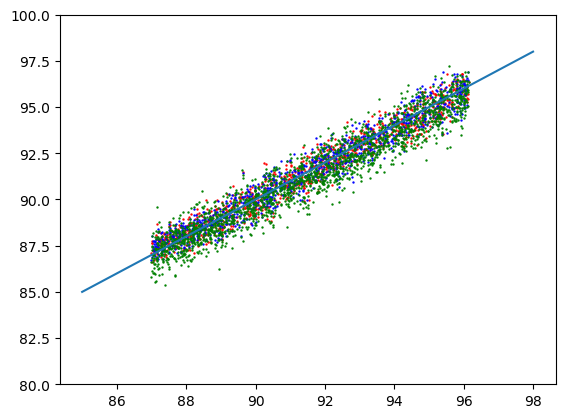

In [147]:
x = np.linspace(85, 98)
plt.scatter(lps_trainS, model_lps_trainS, c='r', s=0.5)
plt.scatter(lps_testS, model_lps_testS, c='b', s=0.5)
plt.scatter(simsLP, modelSimpoly, c='g', s=0.5)
plt.plot(x, x)

plt.ylim(80, 100)

In [99]:
modelSimpoly = []
for i in range(len(simsXi)):
    lp = polyLP(simsR, simsXi[i], 60, 140, 9)
    modelSimpoly.append(lp)

In [105]:
simsLP[0]

88.53756318539176

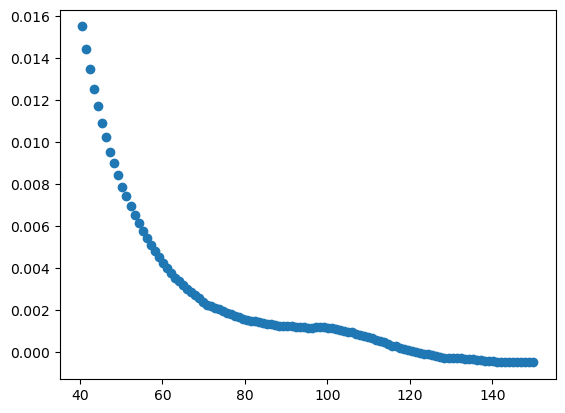

In [110]:
plt.scatter(simsR, simsXi[235])

# 1. Set all neural networks

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Model 1: Fully connected neural network on Quijote latin hypercube, z=0

In [9]:
inputStart, inputEnd = 40, 160
trainTestSplit = 999
inputs_r, inputs_xi, lps = dataPull(inputStart, inputEnd, z=0)

In [10]:
train_dataloader, test_dataloader = setDataloaders(inputs_xi, lps, trainTestSplit)

In [11]:
inputs_r3, inputs_xi3, lps3 = dataPull(inputStart, inputEnd, z=3)

In [12]:
inputs_r1, inputs_xi1, lps1 = dataPull(inputStart, inputEnd, z=1)

In [13]:
# run this cell to load the saved model
model = encoder(input_shape=len(inputs_xi[0]), features=32).to(device)
model.load_state_dict(torch.load('scaleNNmodels/quickModel1.pth'))
model.eval()

encoder(
  (encoder): Sequential(
    (0): Linear(in_features=41, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
  )
)

#### Model 2: Fully connected neural network on Quijote latin hypercube, z=0, normalized so each CF has same amplitude at 40 Mpc/h

In [14]:
normalized_inputs_xi = np.zeros((inputs_xi.shape[0], inputs_xi.shape[1]-1))
normalized_inputs_xi1 = np.zeros((inputs_xi1.shape[0], inputs_xi1.shape[1]-1))
normalized_inputs_xi3 = np.zeros((inputs_xi3.shape[0], inputs_xi3.shape[1]-1))

In [15]:
for index in range(len(inputs_xi)):
    normalizedInputXi = np.copy(inputs_xi[index])
    normalizedInputXi /= normalizedInputXi[0]
    normalized_inputs_xi[index] = np.delete(normalizedInputXi, 0)
    
for index in range(len(inputs_xi1)):
    normalizedInputXi = np.copy(inputs_xi1[index])
    normalizedInputXi /= normalizedInputXi[0]
    normalized_inputs_xi1[index] = np.delete(normalizedInputXi, 0)

for index in range(len(inputs_xi3)):
    normalizedInputXi = np.copy(inputs_xi3[index])
    normalizedInputXi /= normalizedInputXi[0]
    normalized_inputs_xi3[index] = np.delete(normalizedInputXi, 0)

In [16]:
train_dataloader_normalized, test_dataloader_normalized = setDataloaders(normalized_inputs_xi, lps, trainTestSplit, inputNormalize=True)

In [17]:
modelNormalized = encoder(input_shape=len(normalized_inputs_xi[0]), features=32).to(device)
modelNormalized.load_state_dict(torch.load('scaleNNmodels/quickModelNormalized.pth'))
modelNormalized.eval()

encoder(
  (encoder): Sequential(
    (0): Linear(in_features=40, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
  )
)

#### Model 3: Fully connected neural network on Quijote latin hypercube, z=0, with data cuts on $\Sigma_b/\Sigma_m$ and $n_s$. normalized so each CF has same amplitude at 40 Mpc/h

In [15]:
inputs_rMask, inputs_xiMask, lpsMask = dataPullMask(inputStart, inputEnd)

In [16]:
normalized_inputs_xiMask = np.zeros((inputs_xiMask.shape[0], inputs_xiMask.shape[1]-1))

In [17]:
for index in range(len(inputs_xiMask)):
    normalizedInputXiMask = np.copy(inputs_xiMask[index])
    normalizedInputXiMask /= normalizedInputXiMask[0]
    normalized_inputs_xiMask[index] = np.delete(normalizedInputXiMask, 0)

In [18]:
trainTestSplitMask = int(len(inputs_xiMask)/2)

In [19]:
train_dataloaderMask, test_dataloaderMask = setDataloaders(normalized_inputs_xiMask, lpsMask, trainTestSplitMask)

In [20]:
# run this cell to load the saved model
modelMask = encoder(input_shape=len(normalized_inputs_xiMask[0]), features=32).to(device)
modelMask.load_state_dict(torch.load('scaleNNmodels/quickModelMask.pth'))
modelMask.eval()

encoder(
  (encoder): Sequential(
    (0): Linear(in_features=40, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
  )
)

#### Model 4: Fully connected neural network on averaged Quijote fiducial, z=0, shifted (same LP shifts as latin hypercube), normalized

In [59]:
path = 'fiducialCFz0'
dir_list = os.listdir(path)

In [60]:
xiArrayZ0 = np.zeros([len(dir_list), len(txt_to_table_fiducial_z0(0))])
for i in range(len(dir_list)):
    xi = np.array(txt_to_table_fiducial_z0(dir_list[i])['xi'])
    xiArrayZ0[i] = xi

In [61]:
meanFiducialCF = Table([txt_to_table_fiducial_z0(dir_list[i])['r'], np.mean(xiArrayZ0, axis=0)], names=('r', 'xi'))

In [62]:
polyFit = CFpolyFit(meanFiducialCF['r'], meanFiducialCF['xi'], 20, 180, 25)

In [63]:
dPolyFit = polyFit.deriv()
ddPolyFit = dPolyFit.deriv()
criticalPoints = dPolyFit.roots()
realCP = criticalPoints[np.isreal(criticalPoints)]
dipPeak = np.real(realCP[(realCP >= 80) & (realCP <= 100)])
dCriticalPoints = ddPolyFit.roots()
realDCP = dCriticalPoints[np.isreal(dCriticalPoints)]
ip = np.real(realDCP[(realDCP >= 85) & (realDCP <= 95)])[0]
fiducial_lp = np.mean(dipPeak)

dip, peak = dipPeak[0], dipPeak[1]

In [26]:
lpDist = np.copy(scaleTable['lp'])
for i in range(len(lpDist)):
    if lpDist[i] < 75:
        lpDist[i] += 10
    if lpDist[i] > 120:
        lpDist[i] -= 10
lpShifts = lpDist - fiducial_lp

In [27]:
def shiftSample(lpShift, poly, rSampling, polyDeg=25):
    rmin, rmax = np.min(rSampling), np.max(rSampling)
    rArray = np.linspace(rmin, rmax, 1000)
    shifted = CFpolyFit(rArray, poly(rArray-lpShift), rmin, rmax, polyDeg)
    shiftedSampled = shifted(rSampling)
    
    return shiftedSampled

In [28]:
shiftedInputs_xi = np.zeros([len(lpShifts), len(inputs_r[0])])

for i in range(len(lpShifts)):
    shiftedInputs_xi[i] = shiftSample(lpShifts[i], polyFit, inputs_r[0])

In [29]:
normShiftedInputs_xi = np.zeros_like(shiftedInputs_xi)
for i in range(normShiftedInputs_xi.shape[0]):
    normShiftedInputs_xi[i] = shiftedInputs_xi[i]/shiftedInputs_xi[i, 0]

In [30]:
train_dataloaderShifted, test_dataloaderShifted = setDataloaders(normShiftedInputs_xi, lpDist, trainTestSplit, inputNormalize=False)

In [31]:
# run this cell to load the saved model
modelShifted = encoder(input_shape=len(inputs_r[0]), features=32).to(device)
modelShifted.load_state_dict(torch.load('scaleNNmodels/quickModelShifted.pth'))
modelShifted.eval()

encoder(
  (encoder): Sequential(
    (0): Linear(in_features=41, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
  )
)

#### Model 5: Fully connected neural network on averaged Quijote fiducial, z=0, shifted (same LP shifts as latin hypercube), normalized, random error added, random constant offset added

In [32]:
xiErr = np.random.normal(0, 0.3, normShiftedInputs_xi.shape)
normShiftedErrInputs_xi = normShiftedInputs_xi*xiErr + normShiftedInputs_xi

In [40]:
renormShiftedErrInputs_xi = np.zeros_like(normShiftedErrInputs_xi)
for i in range(normShiftedErrInputs_xi.shape[0]):
    renormShiftedErrInputs_xi[i] = normShiftedErrInputs_xi[i] + np.random.random()
    renormShiftedErrInputs_xi[i] = renormShiftedErrInputs_xi[i]/renormShiftedErrInputs_xi[i, 0]

In [41]:
train_dataloaderShiftedErr, test_dataloaderShiftedErr = setDataloaders(renormShiftedErrInputs_xi, lpDist, trainTestSplit, inputNormalize=False)

In [42]:
# run this cell to load the saved model
modelShiftedErr = encoder(input_shape=len(inputs_r[0]), features=32).to(device)
modelShiftedErr.load_state_dict(torch.load('scaleNNmodels/quickModelShiftedErr.pth'))
modelShiftedErr.eval()

encoder(
  (encoder): Sequential(
    (0): Linear(in_features=41, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
  )
)

#### Extra validation data for Model 5: varying error, constant terms, linear points

In [167]:
extraNumber = 2000
shiftedInputs_xiExtra = np.zeros([extraNumber, len(inputs_r[0])])
lpDistsExtra = np.random.normal(95, 7, extraNumber)

for i in range(len(lpDistsExtra)):
    if lpDistsExtra[i] < 75:
        lpDistsExtra[i] += 10
    if lpDistsExtra[i] > 115:
        lpDistsExtra[i] -= 10
lpShiftsExtra = lpDistsExtra - fiducial_lp

for i in range(len(lpShiftsExtra)):
    shiftedInputs_xiExtra[i] = shiftSample(lpShiftsExtra[i], polyFit, inputs_r[0])

In [168]:
normShiftedInputs_xiExtra = np.zeros_like(shiftedInputs_xiExtra)
for i in range(normShiftedInputs_xiExtra.shape[0]):
    normShiftedInputs_xiExtra[i] = shiftedInputs_xiExtra[i]/shiftedInputs_xiExtra[i, 0]

In [246]:
xiErr2 = np.random.normal(0, 0.2, normShiftedInputs_xiExtra.shape)
normShiftedErrInputs_xi2 = normShiftedInputs_xiExtra + normShiftedInputs_xiExtra*xiErr2

In [247]:
renormShiftedErrInputs_xi2 = np.zeros_like(normShiftedErrInputs_xi2)
for i in range(normShiftedErrInputs_xi2.shape[0]):
    renormShiftedErrInputs_xi2[i] = normShiftedErrInputs_xi2[i] + np.random.random()*0.5
    renormShiftedErrInputs_xi2[i] = renormShiftedErrInputs_xi2[i]/renormShiftedErrInputs_xi2[i, 0]

# 2. Train neural networks

#### Model 1

In [129]:
model, train_loss, test_loss = trainBAOReconNN(model, train_dataloader, test_dataloader, lr=1e-5, epochs=10)

epoch : 1/10, train loss = 25.02493505, test loss = 55.56857638
epoch : 2/10, train loss = 24.93485549, test loss = 55.79237526
epoch : 3/10, train loss = 24.92382144, test loss = 55.83422272
epoch : 4/10, train loss = 25.04255630, test loss = 56.36664311
epoch : 5/10, train loss = 25.03517727, test loss = 56.24044516
epoch : 6/10, train loss = 24.93101390, test loss = 56.04389147
epoch : 7/10, train loss = 24.94826436, test loss = 55.78059905
epoch : 8/10, train loss = 24.98803187, test loss = 56.33856516
epoch : 9/10, train loss = 24.93541802, test loss = 56.10766715
epoch : 10/10, train loss = 25.03891083, test loss = 55.69582660


In [ ]:
torch.save(model.state_dict(), 'scaleNNmodels/quickModel1.pth')

#### Model 2

In [83]:
modelNormalized, train_lossNormalized, test_lossNormalized = trainBAOReconNN(modelNormalized, train_dataloader_normalized, test_dataloader_normalized, lr=1e-5, epochs=10)

epoch : 1/10, train loss = 21.41668145, test loss = 69.97553097
epoch : 2/10, train loss = 21.31150972, test loss = 69.79640582
epoch : 3/10, train loss = 21.22388187, test loss = 69.83151513
epoch : 4/10, train loss = 21.17013407, test loss = 69.91661718
epoch : 5/10, train loss = 21.05776548, test loss = 69.78540260
epoch : 6/10, train loss = 21.00093217, test loss = 69.82058296
epoch : 7/10, train loss = 20.94008511, test loss = 69.65065379
epoch : 8/10, train loss = 20.89223391, test loss = 69.60473525
epoch : 9/10, train loss = 20.84068981, test loss = 69.58634192
epoch : 10/10, train loss = 20.79197248, test loss = 69.50969823


In [ ]:
torch.save(modelNormalized.state_dict(), 'scaleNNmodels/quickModelNormalized.pth')

#### Model 3

In [120]:
modelMask = encoder(input_shape=len(normalized_inputs_xiMask[0]), features=32).to(device)

In [127]:
modelMask, train_lossMask, test_lossMask = trainBAOReconNN(modelMask, train_dataloaderMask, test_dataloaderMask, lr=1e-4, epochs=10)

epoch : 1/10, train loss = 43.53385711, test loss = 68.48501136
epoch : 2/10, train loss = 43.10328648, test loss = 66.22922983
epoch : 3/10, train loss = 43.06495023, test loss = 66.71485511
epoch : 4/10, train loss = 42.51485412, test loss = 65.85816617
epoch : 5/10, train loss = 42.45658540, test loss = 65.81401757
epoch : 6/10, train loss = 42.17481374, test loss = 66.32048449
epoch : 7/10, train loss = 42.03830549, test loss = 66.19040581
epoch : 8/10, train loss = 42.30655987, test loss = 65.03496455
epoch : 9/10, train loss = 41.75442554, test loss = 66.26134309
epoch : 10/10, train loss = 41.88196073, test loss = 65.34229823


In [128]:
torch.save(modelMask.state_dict(), 'scaleNNmodels/quickModelMask.pth')

#### Model 4

In [ ]:
modelShifted, train_lossShifted, test_lossMaskShifted = trainBAOReconNN(modelShifted, train_dataloaderShifted, test_dataloaderShifted, lr=1e-5, epochs=10)

In [ ]:
torch.save(modelShifted.state_dict(), 'scaleNNmodels/quickModelShifted.pth')

#### Model 5

In [59]:
modelShiftedErr = cnn()#encoder(input_shape=len(renormShiftedErrInputs_xi[0]), features=32).to(device)

In [97]:
modelShiftedErr2 = encoder(input_shape=len(renormShiftedErrInputs_xi[0]), features=32).to(device)

In [69]:
modelShiftedErr, train_lossShiftedErr, test_lossMaskShiftedErr = trainBAOReconNN(modelShiftedErr, train_dataloaderShiftedErr, test_dataloaderShiftedErr, lr=1e-5, epochs=200)

epoch : 1/200, train loss = 42.27871524, test loss = 42.86549486
epoch : 2/200, train loss = 42.21702782, test loss = 42.70158821
epoch : 3/200, train loss = 42.90770044, test loss = 43.89144012
epoch : 4/200, train loss = 42.15700013, test loss = 42.57087425
epoch : 5/200, train loss = 42.12258475, test loss = 42.57200003
epoch : 6/200, train loss = 42.80455591, test loss = 43.87396949
epoch : 7/200, train loss = 42.17420618, test loss = 42.50603641
epoch : 8/200, train loss = 42.55470261, test loss = 42.81986363
epoch : 9/200, train loss = 42.09179391, test loss = 42.47429135
epoch : 10/200, train loss = 41.92986236, test loss = 42.48042082
epoch : 11/200, train loss = 41.90302235, test loss = 42.51892604
epoch : 12/200, train loss = 42.03107361, test loss = 42.38580419
epoch : 13/200, train loss = 41.95215456, test loss = 42.64361384
epoch : 14/200, train loss = 41.73548425, test loss = 42.28726260
epoch : 15/200, train loss = 42.24894346, test loss = 42.58071894
epoch : 16/200, tra

In [104]:
modelShiftedErr2, train_lossShiftedErr2, test_lossMaskShiftedErr2 = trainBAOReconNN(modelShiftedErr2, train_dataloaderShiftedErr, test_dataloaderShiftedErr, lr=1e-5, epochs=20)

epoch : 1/20, train loss = 42.69253807, test loss = 47.08953848
epoch : 2/20, train loss = 43.00603192, test loss = 46.87630908
epoch : 3/20, train loss = 42.53114075, test loss = 46.70112949
epoch : 4/20, train loss = 43.33197224, test loss = 47.02198148
epoch : 5/20, train loss = 43.81657059, test loss = 47.43501591
epoch : 6/20, train loss = 42.68985362, test loss = 46.62463461
epoch : 7/20, train loss = 42.54497309, test loss = 46.55321485
epoch : 8/20, train loss = 42.43296921, test loss = 46.71716421
epoch : 9/20, train loss = 42.41684432, test loss = 46.76717334
epoch : 10/20, train loss = 42.36133713, test loss = 46.49538211
epoch : 11/20, train loss = 42.32875112, test loss = 46.52873895
epoch : 12/20, train loss = 42.40981333, test loss = 46.85145597
epoch : 13/20, train loss = 42.61882045, test loss = 46.52819200
epoch : 14/20, train loss = 42.26690730, test loss = 46.48958335
epoch : 15/20, train loss = 42.39886023, test loss = 46.89093937
epoch : 16/20, train loss = 42.387

In [70]:
torch.save(modelShiftedErr.state_dict(), 'scaleNNmodels/quickModelShiftedErr.pth')

# 3. Fit Polynomials to CFs

In [18]:
model1poly = []
for i in range(len(inputs_r)):
    lp = polyLP(inputs_r[i], inputs_xi[i], 60, 140, 9)
    model1poly.append(lp)

In [19]:
model1poly3 = []
for i in range(len(inputs_r3)):
    lp = polyLP(inputs_r3[i], inputs_xi3[i], 60, 140, 9)
    model1poly3.append(lp)

In [20]:
model1poly1 = []
for i in range(len(inputs_r1)):
    lp = polyLP(inputs_r1[i], inputs_xi1[i], 60, 140, 9)
    model1poly1.append(lp)

In [21]:
model2poly = []
for i in range(len(normalized_inputs_xi)):
    r = np.delete(inputs_r[0], 0)
    lp = polyLP(r, normalized_inputs_xi[i], 60, 140, 9)
    model2poly.append(lp)

In [22]:
model2poly1 = []
for i in range(len(normalized_inputs_xi1)):
    r = np.delete(inputs_r1[0], 0)
    lp = polyLP(r, normalized_inputs_xi1[i], 60, 140, 9)
    model2poly1.append(lp)

In [23]:
model2poly3 = []
for i in range(len(normalized_inputs_xi3)):
    r = np.delete(inputs_r3[0], 0)
    lp = polyLP(r, normalized_inputs_xi3[i], 60, 140, 9)
    model2poly3.append(lp)

In [88]:
model3poly = []
for i in range(len(normalized_inputs_xiMask)):
    r = np.delete(inputs_r[0], 0)
    lp = polyLP(r, normalized_inputs_xiMask[i], 60, 140, 9)
    model3poly.append(lp)

In [182]:
model4poly = []
for i in range(len(normShiftedInputs_xi)):
    lp = polyLP(inputs_r[i], normShiftedInputs_xi[i], 60, 140, 9)
    model4poly.append(lp)

In [224]:
model5poly = []
for i in range(len(renormShiftedErrInputs_xi)):
    lp = polyLP(inputs_r[i], renormShiftedErrInputs_xi[i], 60, 140, 9)
    model5poly.append(lp)

In [225]:
model5poly2 = []
for i in range(len(renormShiftedErrInputs_xi2)):
    lp = polyLP(inputs_r[0], renormShiftedErrInputs_xi2[i], 60, 140, 9)
    model5poly2.append(lp)

# 3. Plot Neural Network Outputs

#### Model 1

In [24]:
mean_inputs, mean_lps, var_inputs, var_lps = meanVar(inputs_xi[:trainTestSplit], lps[:trainTestSplit])

In [25]:
model_lps = []
for i in inputs_xi:
    normalized_inputs = (np.copy(i) - mean_inputs)/var_inputs
    model_lp = model(torch.Tensor(normalized_inputs)).item()*var_lps+mean_lps
    model_lps.append(model_lp)

model_lps = np.array(model_lps)

In [26]:
model_lps3 = []
for i in inputs_xi3:
    normalized_inputs = (np.copy(i) - mean_inputs)/var_inputs
    model_lp = model(torch.Tensor(normalized_inputs)).item()*var_lps+mean_lps
    model_lps3.append(model_lp)

model_lps3 = np.array(model_lps3)

In [27]:
model_lps1 = []
for i in inputs_xi1:
    normalized_inputs = (np.copy(i) - mean_inputs)/var_inputs
    model_lp = model(torch.Tensor(normalized_inputs)).item()*var_lps+mean_lps
    model_lps1.append(model_lp)

model_lps1 = np.array(model_lps1)

In [28]:
lps_train = lps[:trainTestSplit]
model_lps_train = model_lps[:trainTestSplit]

lps_test = lps[trainTestSplit:]
model_lps_test = model_lps[trainTestSplit:]

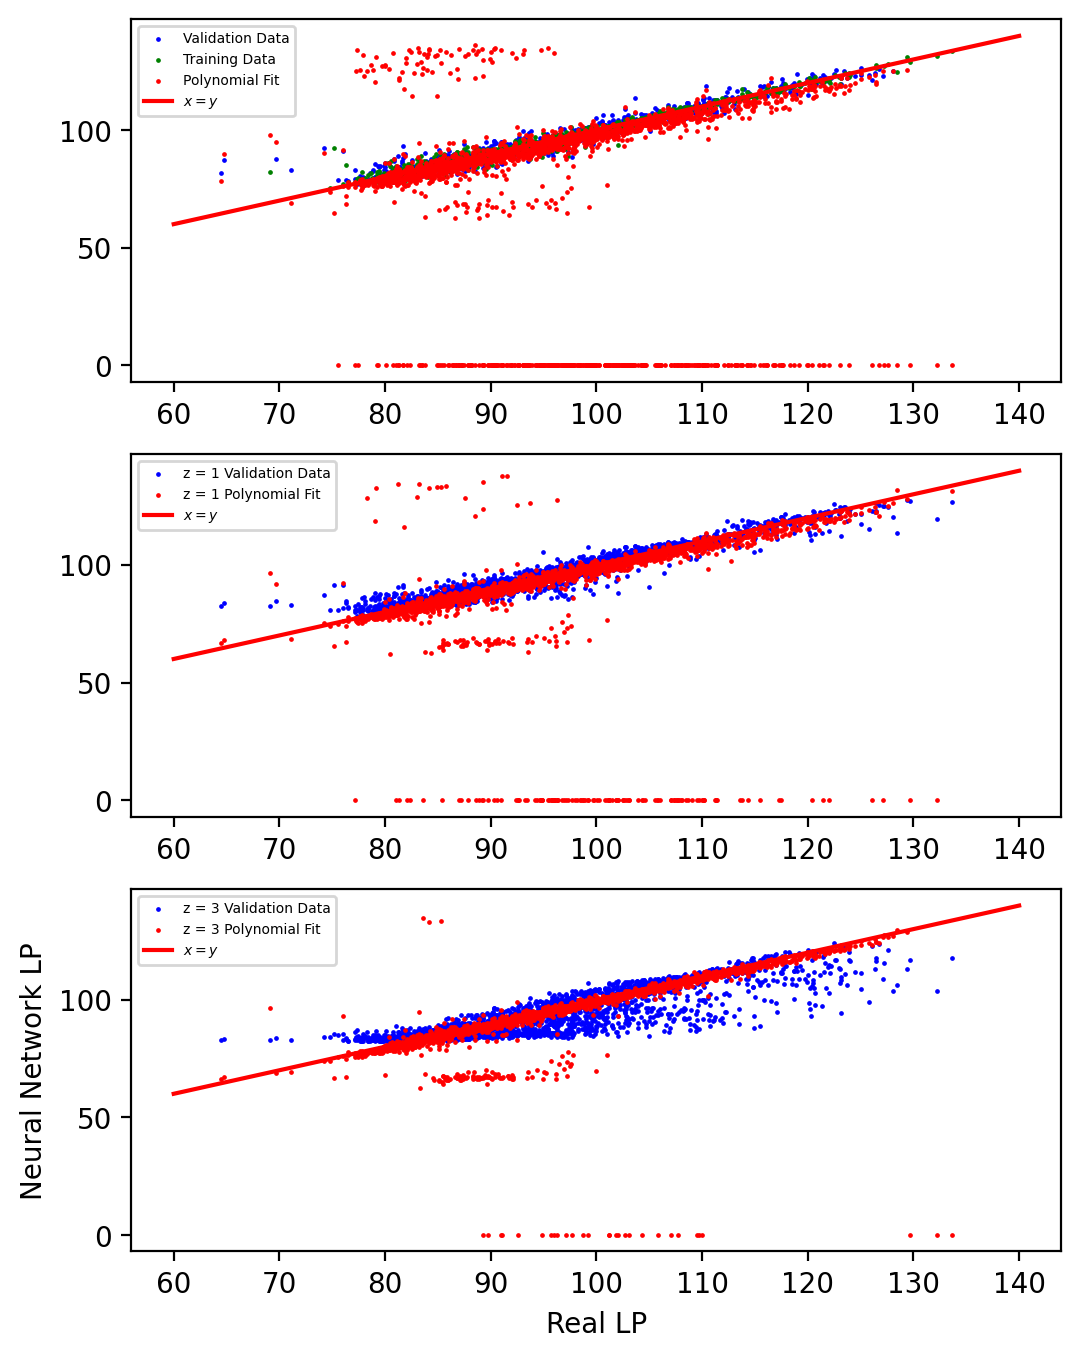

In [39]:
fig, ax = plt.subplots(3, figsize=[6,8], dpi=200)
lineX = np.linspace(60, 140, 100)
ax[0].scatter(lps_test, model_lps_test, c='b', s=0.5, label='Validation Data')
ax[0].scatter(lps_train, model_lps_train, c='g', s=0.5, label='Training Data')
ax[0].scatter(lps, model1poly, c='r', s=0.5, label='Polynomial Fit')

ax[1].scatter(lps1, model_lps1, c='b', s=0.5, label='z = 1 Validation Data')
ax[1].scatter(lps1, model1poly1, c='r', s=0.5, label='z = 1 Polynomial Fit')


ax[2].scatter(lps3, model_lps3, c='b', s=0.5, label='z = 3 Validation Data')
ax[2].scatter(lps3, model1poly3, c='r', s=0.5, label='z = 3 Polynomial Fit')



for axis in ax:
    axis.plot(lineX, lineX, c='r', label='$x=y$')
    p = axis.legend(fontsize=5)

plt.xlabel('Real LP')
p = plt.ylabel('Neural Network LP')

#### Model 2

In [30]:
mean_inputs_normalized, mean_lps_normalized, var_inputs_normalized, var_lps_normalized = meanVar(normalized_inputs_xi[:trainTestSplit], lps[:trainTestSplit])

In [31]:
model_lps_normalized = []
for i in normalized_inputs_xi:
    normalized_inputs = (np.copy(i) - mean_inputs_normalized)/var_inputs_normalized
    model_lp = modelNormalized(torch.Tensor(normalized_inputs)).item()*var_lps_normalized+mean_lps_normalized
    model_lps_normalized.append(model_lp)

model_lps_normalized = np.array(model_lps_normalized)

In [32]:
model_lps1_normalized = []
for i in normalized_inputs_xi1:
    normalized_inputs = (np.copy(i) - mean_inputs_normalized)/var_inputs_normalized
    model_lp = modelNormalized(torch.Tensor(normalized_inputs)).item()*var_lps_normalized+mean_lps_normalized
    model_lps1_normalized.append(model_lp)

model_lps1_normalized = np.array(model_lps1_normalized)

In [33]:
model_lps3_normalized = []
for i in normalized_inputs_xi3:
    normalized_inputs = (np.copy(i) - mean_inputs_normalized)/var_inputs_normalized
    model_lp = modelNormalized(torch.Tensor(normalized_inputs)).item()*var_lps_normalized+mean_lps_normalized
    model_lps3_normalized.append(model_lp)

model_lps3_normalized = np.array(model_lps3_normalized)

In [34]:
model_lps_train_normalized = model_lps_normalized[:trainTestSplit]

model_lps_test_normalized = model_lps_normalized[trainTestSplit:]

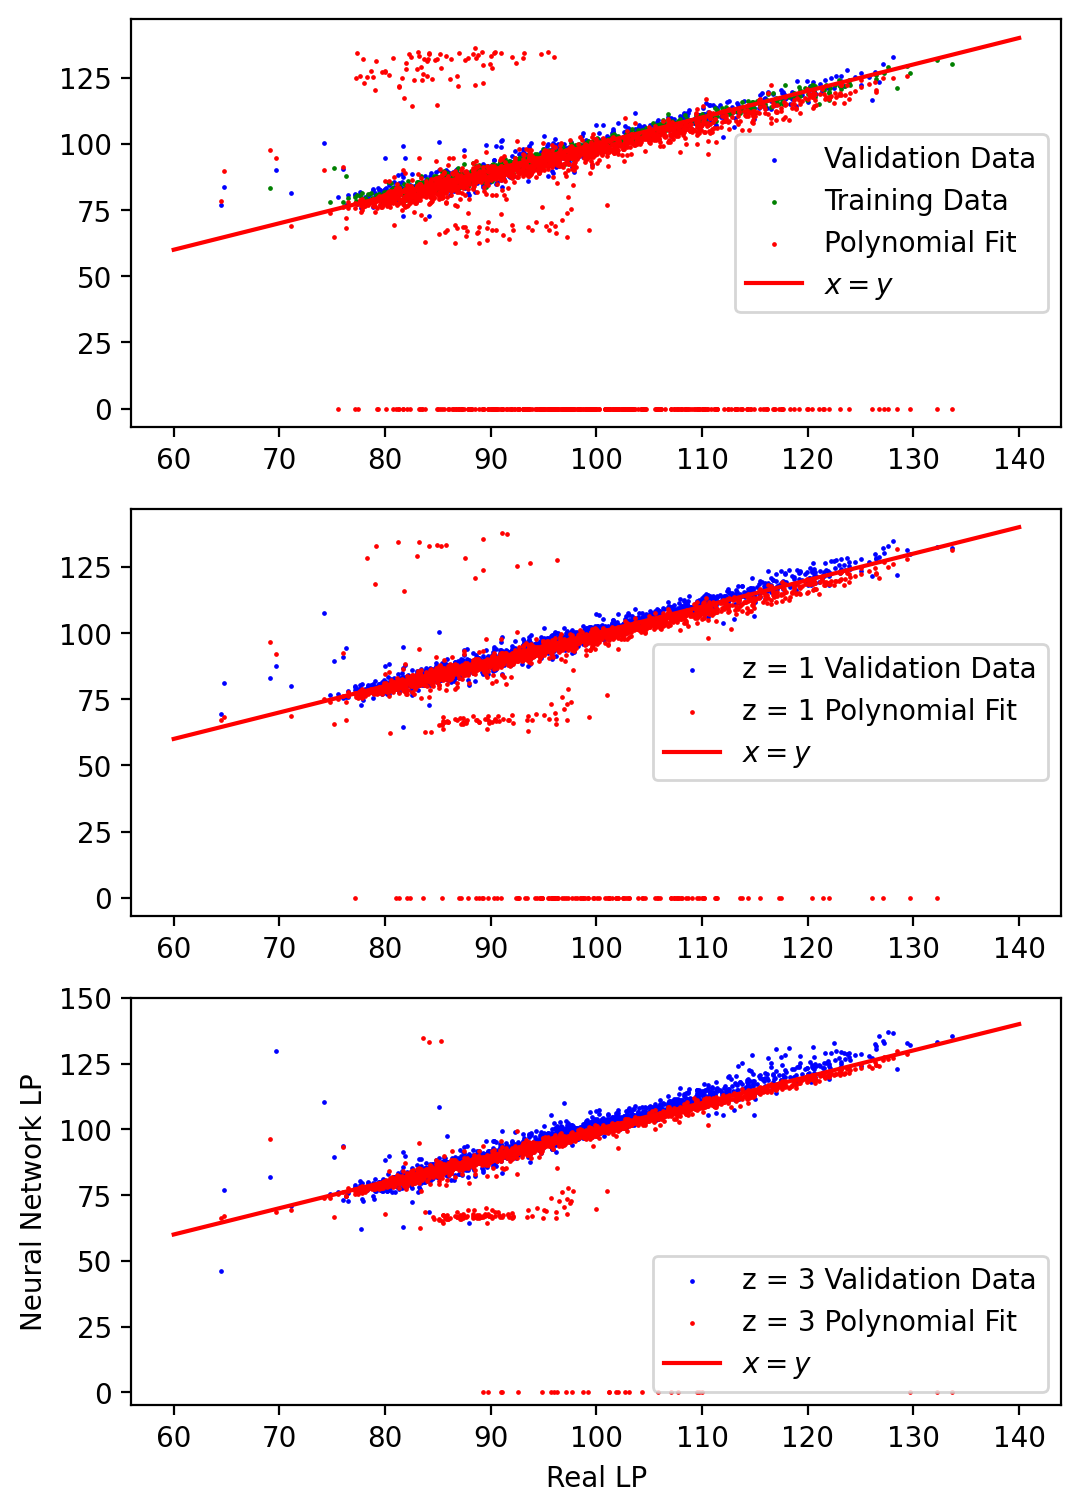

In [41]:
fig, ax = plt.subplots(3, figsize=[6,9], dpi=200)
lineX = np.linspace(60, 140, 100)
ax[0].scatter(lps_test, model_lps_test_normalized, c='b', s=0.5, label='Validation Data')
ax[0].scatter(lps_train, model_lps_train_normalized, c='g', s=0.5, label='Training Data')
ax[0].scatter(lps, model2poly, c='r', s=0.5, label='Polynomial Fit')

ax[1].scatter(lps, model_lps1_normalized, c='b', s=0.5, label='z = 1 Validation Data')
ax[1].scatter(lps, model2poly1, c='r', s=0.5, label='z = 1 Polynomial Fit')

ax[2].scatter(lps, model_lps3_normalized, c='b', s=0.5, label='z = 3 Validation Data')
ax[2].scatter(lps, model2poly3, c='r', s=0.5, label='z = 3 Polynomial Fit')

for axis in ax:
    axis.plot(lineX, lineX, c='r', label='$x=y$')
    axis.legend()

plt.xlabel('Real LP')
plt.ylabel('Neural Network LP')
ax[2].set_ylim(-5, 150)
p = plt.legend()

#### Model 3

In [123]:
mean_inputs_mask, mean_lps_mask, var_inputs_mask, var_lps_mask = meanVar(normalized_inputs_xiMask[:trainTestSplitMask], lpsMask[:trainTestSplitMask])

In [124]:
model_lps_mask = []
for i in normalized_inputs_xiMask:
    normalized_inputs = (np.copy(i) - mean_inputs_mask)/var_inputs_mask
    model_lp = modelMask(torch.Tensor(normalized_inputs)).item()*var_lps_mask+mean_lps_mask
    model_lps_mask.append(model_lp)

model_lps_mask = np.array(model_lps_mask)

In [125]:
lps_train_mask = lpsMask[:trainTestSplitMask]
model_lps_train_mask = model_lps_mask[:trainTestSplitMask]

lps_test_mask = lpsMask[trainTestSplitMask:]
model_lps_test_mask = model_lps_mask[trainTestSplitMask:]

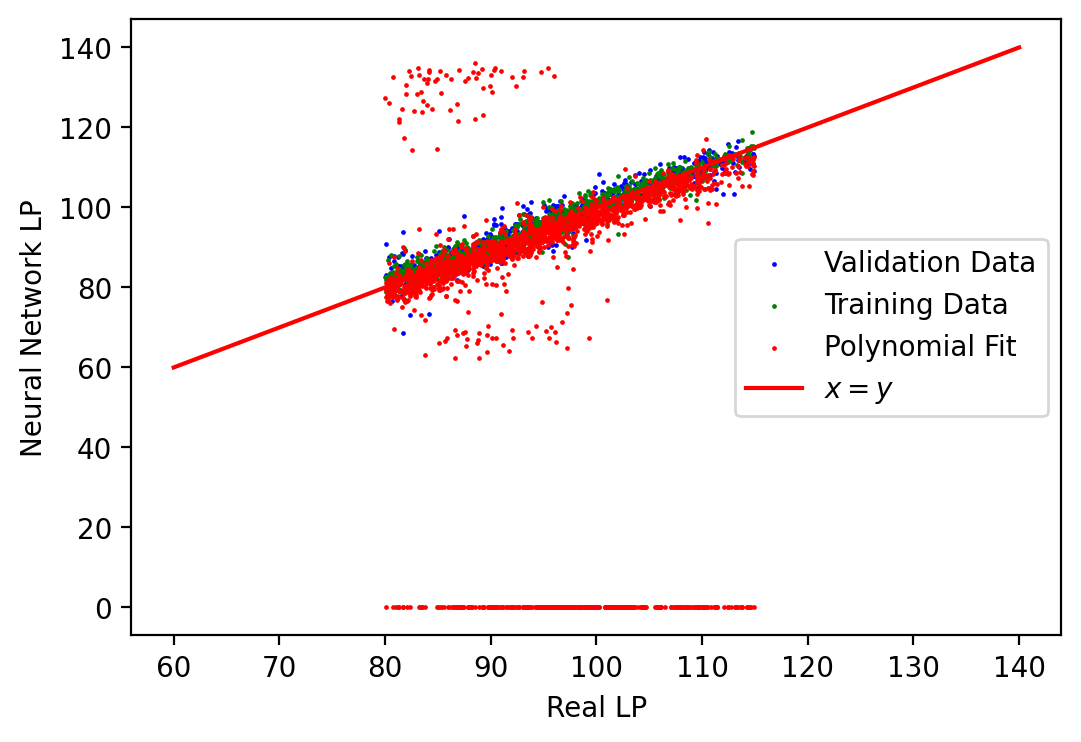

In [239]:
fig = plt.figure(figsize=[6,4], dpi=200)
lineX = np.linspace(60, 140, 100)
plt.scatter(lps_test_mask, model_lps_test_mask, c='b', s=0.5, label='Validation Data')
plt.scatter(lps_train_mask, model_lps_train_mask, c='g', s=0.5, label='Training Data')
plt.scatter(lpsMask, model3poly, c='r', s=0.5, label='Polynomial Fit')


plt.plot(lineX, lineX, c='r', label='$x=y$')

plt.xlabel('Real LP')
plt.ylabel('Neural Network LP')
p = plt.legend()

#### Model 4

In [157]:
mean_inputs_shifted, mean_lps_shifted, var_inputs_shifted, var_lps_shifted = meanVar(normShiftedInputs_xi[:trainTestSplit], lpDist[:trainTestSplit])

In [158]:
model_lps_shifted = []
for i in normShiftedInputs_xi:
    model_lp = modelShifted(torch.Tensor(i)).item()*var_lps_shifted+mean_lps_shifted
    model_lps_shifted.append(model_lp)

model_lps_shifted = np.array(model_lps_shifted)

In [159]:
lps_train_shifted = lpDist[:trainTestSplit]
model_lps_train_shifted = model_lps_shifted[:trainTestSplit]

lps_test_shifted = lpDist[trainTestSplit:]
model_lps_test_shifted = model_lps_shifted[trainTestSplit:]

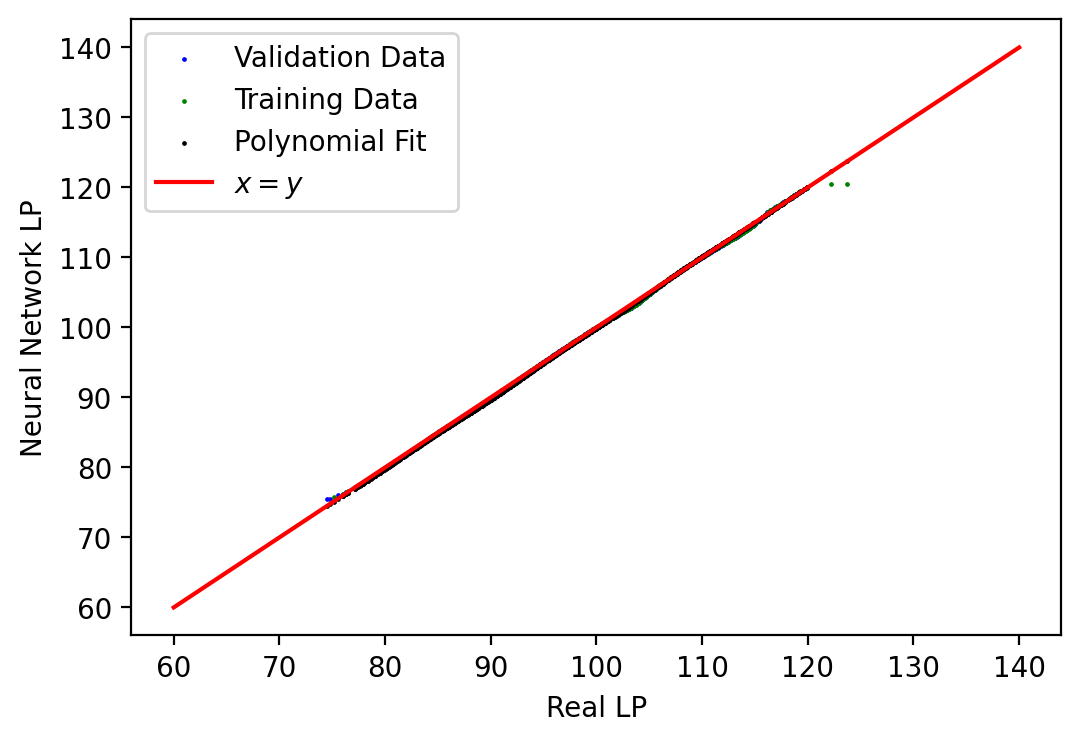

In [245]:
fig = plt.figure(figsize=[6,4], dpi=200)
lineX = np.linspace(60, 140, 100)
plt.scatter(lps_test_shifted, model_lps_test_shifted, c='b', s=0.5, label='Validation Data')
plt.scatter(lps_train_shifted, model_lps_train_shifted, c='g', s=0.5, label='Training Data')
plt.scatter(lpDist, model4poly, c='k', s=0.5, label='Polynomial Fit')


plt.plot(lineX, lineX, c='r', label='$x=y$')

plt.xlabel('Real LP')
plt.ylabel('Neural Network LP')
p = plt.legend()

#### Model 5

In [263]:
mean_inputs_shiftedErr, mean_lps_shiftedErr, var_inputs_shiftedErr, var_lps_shiftedErr = meanVar(renormShiftedErrInputs_xi[:trainTestSplit], lpDist[:trainTestSplit])

In [264]:
model_lps_shiftedErrCNN = []
for i in renormShiftedErrInputs_xi:
    model_lp = modelShiftedErr(torch.Tensor(i)).item()*var_lps_shiftedErr+mean_lps_shiftedErr
    model_lps_shiftedErrCNN.append(model_lp)

model_lps_shiftedErrCNN = np.array(model_lps_shiftedErrCNN)

In [265]:
model_lps_shiftedErr = []
for i in renormShiftedErrInputs_xi:
    model_lp = modelShiftedErr2(torch.Tensor(i)).item()*var_lps_shiftedErr+mean_lps_shiftedErr
    model_lps_shiftedErr.append(model_lp)

model_lps_shiftedErr = np.array(model_lps_shiftedErr)

In [266]:
model_lps_shiftedErr2 = []
for i in renormShiftedErrInputs_xi2:
    model_lp = modelShiftedErr2(torch.Tensor(i)).item()*var_lps_shiftedErr+mean_lps_shiftedErr
    model_lps_shiftedErr2.append(model_lp)

model_lps_shiftedErr2 = np.array(model_lps_shiftedErr2)

In [267]:
model_lps_shiftedErrCNN2 = []
for i in renormShiftedErrInputs_xi2:
    model_lp = modelShiftedErr(torch.Tensor(i)).item()*var_lps_shiftedErr+mean_lps_shiftedErr
    model_lps_shiftedErrCNN2.append(model_lp)

model_lps_shiftedErrCNN2 = np.array(model_lps_shiftedErrCNN2)

In [268]:
model_lps_shiftedNoErrCNN = []
for i in normShiftedInputs_xi:
    model_lp = modelShiftedErr(torch.Tensor(i)).item()*var_lps_shiftedErr+mean_lps_shiftedErr
    model_lps_shiftedNoErrCNN.append(model_lp)

model_lps_shiftedNoErrCNN = np.array(model_lps_shiftedNoErrCNN)

In [269]:
model_lps_shiftedNoErr = []
for i in normShiftedInputs_xi:
    model_lp = modelShiftedErr2(torch.Tensor(i)).item()*var_lps_shiftedErr+mean_lps_shiftedErr
    model_lps_shiftedNoErr.append(model_lp)

model_lps_shiftedNoErr = np.array(model_lps_shiftedNoErr)

In [270]:
lps_train_shiftedErr = lpDist[:trainTestSplit]
model_lps_train_shiftedErr = model_lps_shiftedErr[:trainTestSplit]

lps_test_shiftedErr = lpDist[trainTestSplit:]
model_lps_test_shiftedErr = model_lps_shiftedErr[trainTestSplit:]

model_lps_train_shiftedErrCNN = model_lps_shiftedErrCNN[:trainTestSplit]

model_lps_test_shiftedErrCNN = model_lps_shiftedErrCNN[trainTestSplit:]

In [276]:
lpDist[0], lpDistsExtra[0]

(104.46862969002774, 95.44704592697914)

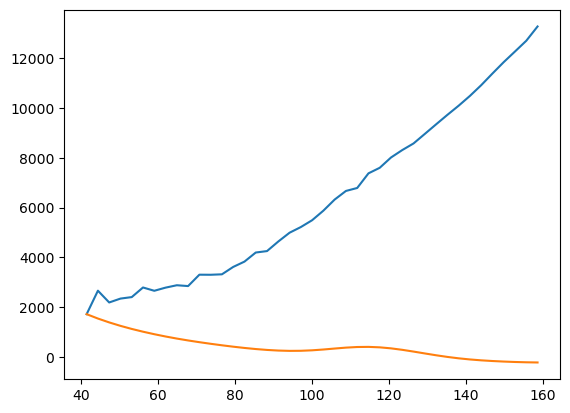

In [279]:
plt.plot(inputs_r[0], renormShiftedErrInputs_xi[0]*inputs_r[0]**2)
plt.plot(inputs_r[0], normShiftedInputs_xi[0]*inputs_r[0]**2)

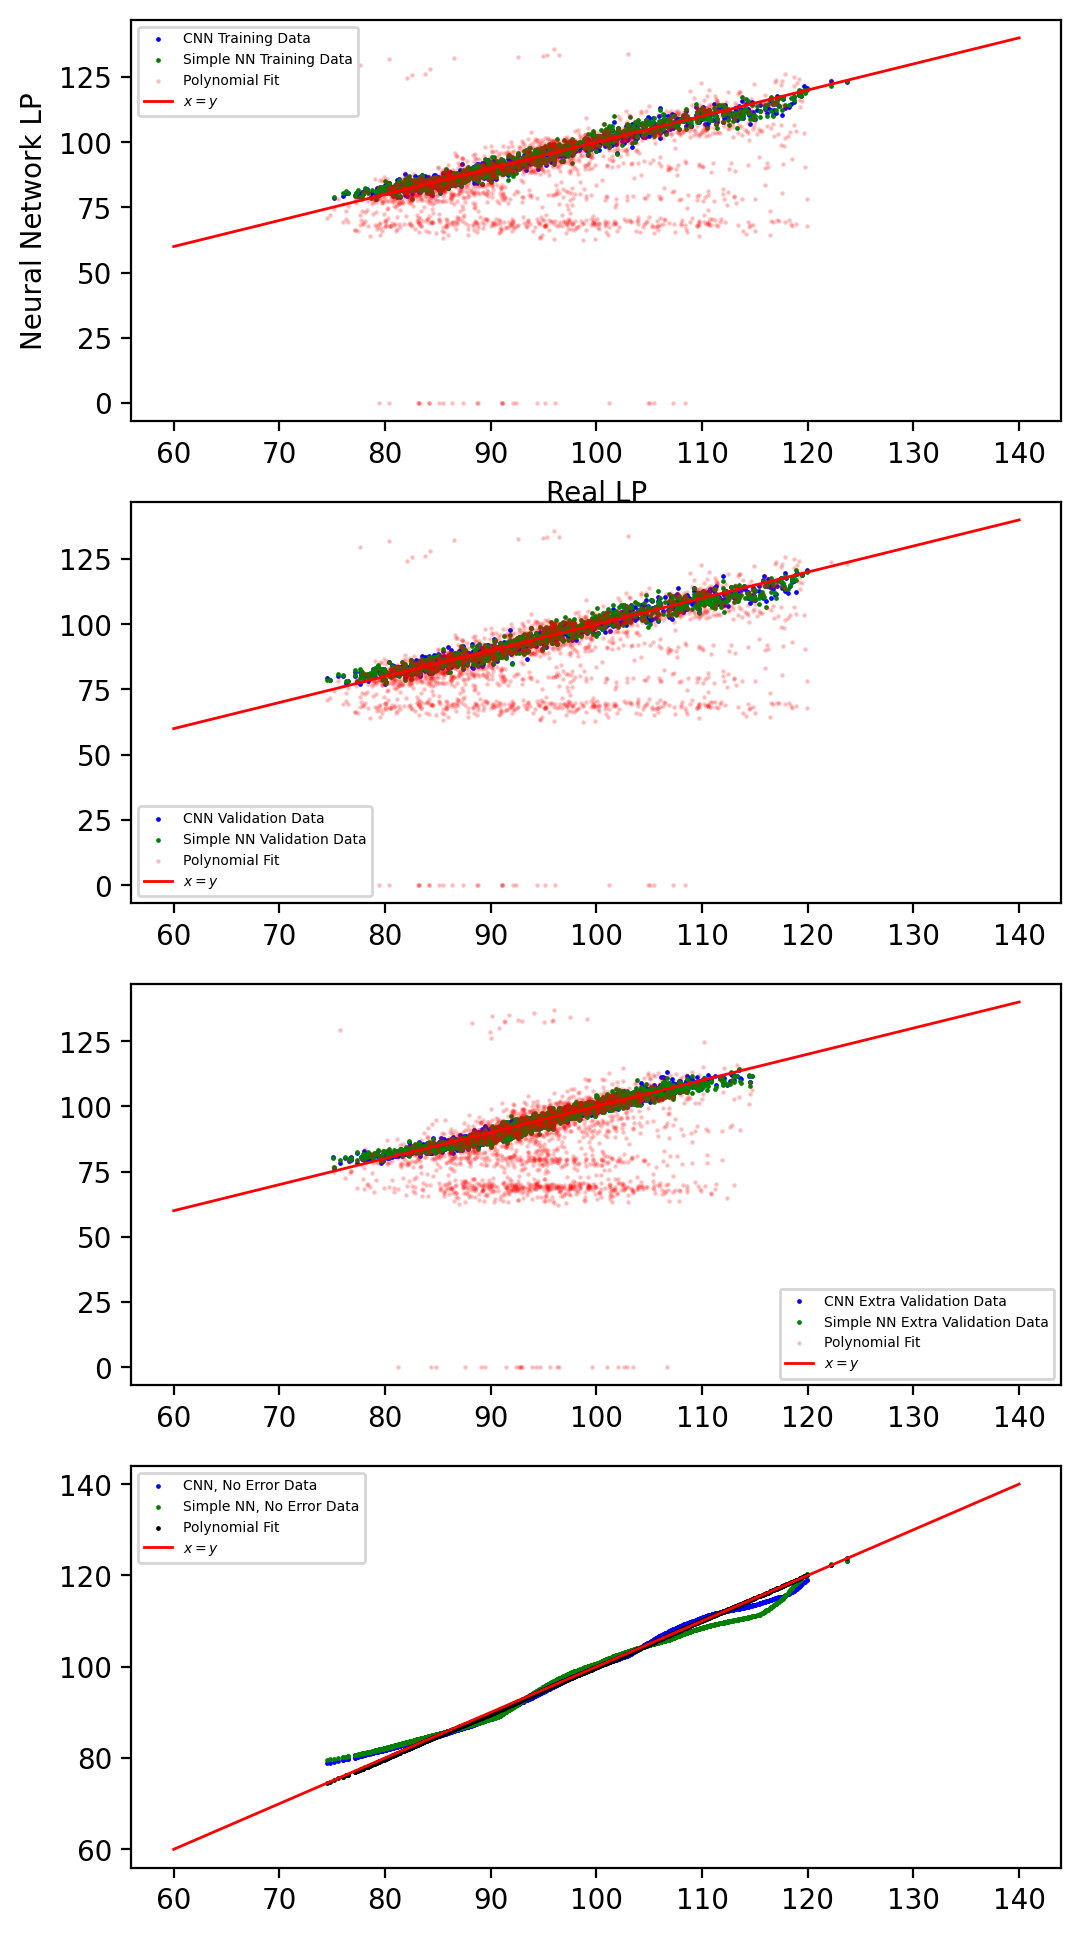

In [271]:
fig, ax = plt.subplots(4, figsize=[6, 12], dpi=200)
lineX = np.linspace(60, 140, 100)

ax[0].scatter(lps_train_shiftedErr, model_lps_train_shiftedErrCNN, c='b', s=0.5, label='CNN Training Data')
ax[0].scatter(lps_train_shiftedErr, model_lps_train_shiftedErr, c='g', s=0.5, label='Simple NN Training Data')
ax[0].scatter(lpDist, model5poly, c='r', s=0.5, label='Polynomial Fit', alpha=0.2)


ax[1].scatter(lps_test_shiftedErr, model_lps_test_shiftedErrCNN, c='b', s=0.5, label='CNN Validation Data')
ax[1].scatter(lps_test_shiftedErr, model_lps_test_shiftedErr, c='g', s=0.5, label='Simple NN Validation Data')
ax[1].scatter(lpDist, model5poly, c='r', s=0.5, label='Polynomial Fit', alpha=0.2)


ax[2].scatter(lpDistsExtra, model_lps_shiftedErrCNN2, c='b', s=0.5, label='CNN Extra Validation Data')
ax[2].scatter(lpDistsExtra, model_lps_shiftedErr2, c='g', s=0.5, label='Simple NN Extra Validation Data')
ax[2].scatter(lpDistsExtra, model5poly2, c='r', s=0.5, label='Polynomial Fit', alpha=0.2)


ax[3].scatter(lpDist, model_lps_shiftedNoErrCNN, c='b', s=0.5, label='CNN, No Error Data')
ax[3].scatter(lpDist, model_lps_shiftedNoErr, c='g', s=0.5, label='Simple NN, No Error Data')
ax[3].scatter(lpDist, model4poly, c='k', s=0.5, label='Polynomial Fit')



ax[0].plot(lineX, lineX, c='r', label='$x=y$', lw=1)
ax[1].plot(lineX, lineX, c='r', label='$x=y$', lw=1)
ax[2].plot(lineX, lineX, c='r', label='$x=y$', lw=1)
ax[3].plot(lineX, lineX, c='r', label='$x=y$', lw=1)


ax[0].set_xlabel('Real LP')
ax[0].set_ylabel('Neural Network LP')
#plt.ylim(60, 140)
p = ax[0].legend(fontsize=5)
p = ax[1].legend(fontsize=5)
p = ax[2].legend(fontsize=5)
p = ax[3].legend(fontsize=5)

# 4. Additional Analysis

### Check if residuals correlate to cosmological parameters

In [47]:
trainResiduals = model_lps_train - lps_train
testResiduals = model_lps_test - lps_test

Pull Quijote parameters into a table (and remove the two CFs without a peak and/or dip)

In [48]:
simulation = 'latinHypercubeParameters.txt'
param_list = []
for line in open(simulation, 'r'): # get each line
    item = line.rstrip() # strip off newline and any other trailing whitespace
    param_list.append(item)

del param_list[0]

omegaMlist, omegaBlist, hList, nsList, s8list, cfList = [], [], [], [], [], []
i = 0
for item in param_list: # get radius and correlation from each line
    omegaM, omegaB, h, ns, s8 = item.split() # each line has both radius and correlation, so split
    omegaMlist.append(float(omegaM))
    omegaBlist.append(float(omegaB))
    hList.append(float(h))
    nsList.append(float(ns))
    s8list.append(float(s8))
    cfList.append(i)
    i += 1

    param_table = Table([cfList, omegaMlist, omegaBlist, hList, nsList, s8list],
                        names=('CF', 'omegaM', 'omegaB', 'h', 'ns', 's8')) # astropy table

# Keep the two "bad" CFs separate, then delete them
param244 = Table(param_table[244])
param763 = Table(param_table[763])

param_table.remove_rows([244, 763])

First look at the parameters for the two "bad" CFs

In [49]:
param244

CF,omegaM,omegaB,h,ns,s8
int64,float64,float64,float64,float64,float64
244,0.3207,0.03273,0.5145,0.8469,0.8307


In [50]:
param763

CF,omegaM,omegaB,h,ns,s8
int64,float64,float64,float64,float64,float64
763,0.26570000000000005,0.03033,0.5277000000000001,0.8373,0.9307000000000001


These seem to have relatively low $\Omega_b$ values, and maybe also low $h$ and $n_s$ values in the latin hypercube parameter space:
<img src="quijoteParams.png" alt="Drawing" style="width: 200px;"/>

Now look at the residuals

In [51]:
testOmegaM = param_table['omegaM'][trainTestSplit:]
testOmegaB = param_table['omegaB'][trainTestSplit:]

trainOmegaM = param_table['omegaM'][:trainTestSplit]
trainOmegaB = param_table['omegaB'][:trainTestSplit]

### Interactive Plot

In [46]:
%matplotlib widget

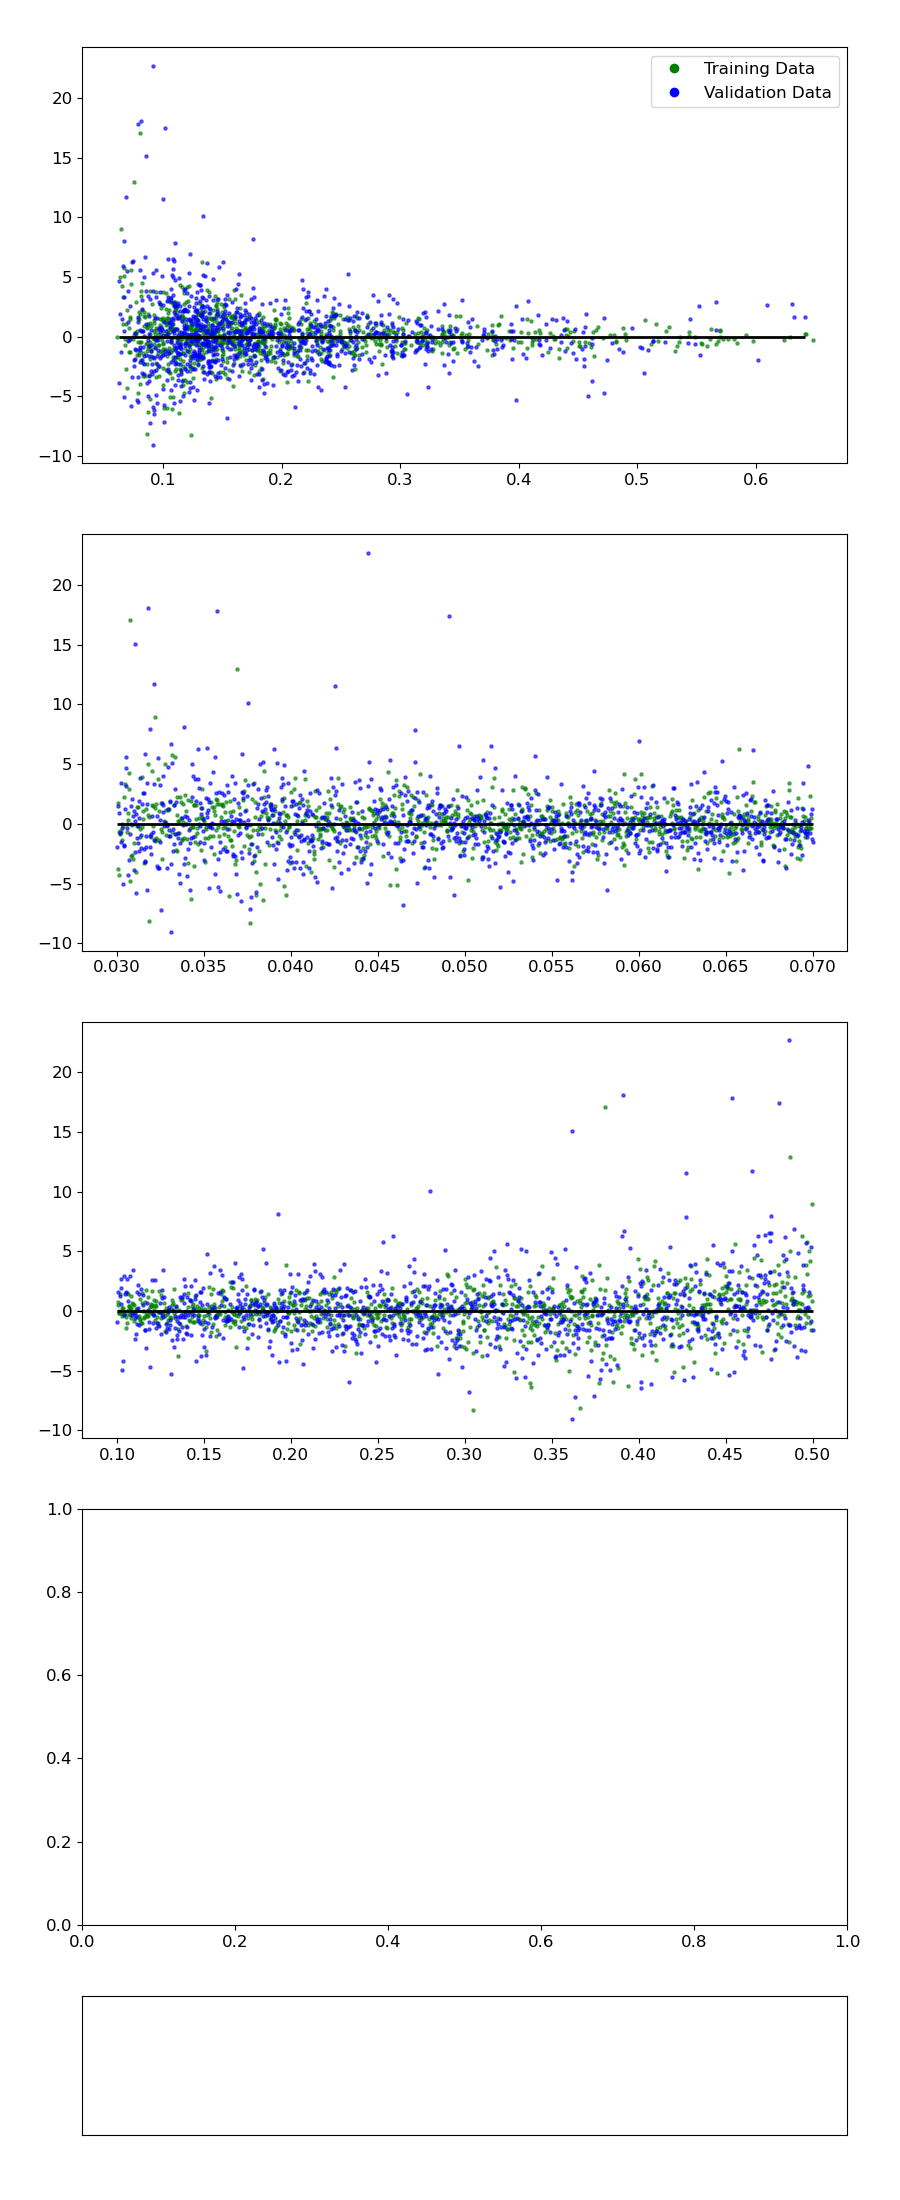

In [55]:
fig, ax = plt.subplots(5, figsize=[9, 22], dpi=100, gridspec_kw={'height_ratios': [3, 3, 3, 3, 1]})
fig.tight_layout(pad=3)
for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Training Data',
                          markerfacecolor='g', markersize=8),
                  Line2D([0], [0], marker='o', color='w', label='Validation Data',
                          markerfacecolor='b', markersize=8)]

props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax[4].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

def plotResidualCollection():
    ax[0].scatter(trainOmegaB/trainOmegaM, trainResiduals, s=5, c='g', picker=True, alpha=0.6, label='Train')
    ax[1].scatter(trainOmegaB, trainResiduals, s=5, c='g', picker=True, alpha=0.6, label='Train')
    ax[2].scatter(trainOmegaM, trainResiduals, s=5, c='g', picker=True, alpha=0.6, label='Train')
    
    ax[0].scatter(testOmegaB/testOmegaM, testResiduals, s=5, c='b', picker=True, alpha=0.6, label='Test')
    ax[1].scatter(testOmegaB, testResiduals, s=5, c='b', picker=True, alpha=0.6, label='Test')
    ax[2].scatter(testOmegaM, testResiduals, s=5, c='b', picker=True, alpha=0.6, label='Test')
    
    ax[0].hlines(y=0, xmin=np.min(testOmegaB/testOmegaM), xmax=np.max(testOmegaB/testOmegaM), color='black', linewidth=2)
    ax[1].hlines(y=0, xmin=np.min(testOmegaB), xmax=np.max(testOmegaB), color='black', linewidth=2)
    ax[2].hlines(y=0, xmin=np.min(testOmegaM), xmax=np.max(testOmegaM), color='black', linewidth=2)

def axis3(axis, number, z3scale=1):
    linCFfile = ascii.read(f'linearCF/linearCF{number}.dat')  
    linCF = Table(linCFfile)
    
    nonLin = txt_to_table(number, 0) # z = 0
    nonLin3 = txt_to_table(number, 3) # z = 3
    
    dip, peak, lp, ip = scales(linCF)
    
    # Plotting
    spl = UnivariateSpline(linCF['r'], linCF['xi'], k=4, s=0) # degree 4 spline fit

    ## Add vertical/horizontal width in plot ##
    r_min, r_max = dip - 50, peak + 50
    if spl(peak) <= 0:
        xi_max = -1*spl(peak)
    else:
        xi_max = spl(peak)*1.2
    if np.min(linCF['xi']) <= 0:
        xi_min = np.min(linCF['xi'])*1.4
    else:
        xi_min = np.min(linCF['xi'])*0.8
        

    axis.plot(linCF['r'], linCF['xi'], c='r', label='Linear z=0 CF')

    axis.vlines([dip, peak], ymin=xi_min, ymax=xi_max, color='r', lw=0.5, ls='-.', label='Dip/peak')
    axis.vlines(lp, ymin=xi_min, ymax=xi_max, color='b', lw=0.5, ls='-.', label='LP')
    axis.vlines(ip, ymin=xi_min, ymax=xi_max, color='g', lw=0.5, ls='-.', label='IP')
    axis.scatter([dip, peak, lp, ip], [spl(dip), spl(peak), spl(lp), spl(ip)], c=['r', 'r', 'b', 'g'], s=2, zorder=1000)

    axis.plot(nonLin['r'], nonLin['xi'], label='Quijote z=0 CF', lw=2, c='b')
    axis.plot(nonLin3['r'], nonLin3['xi']*z3scale, label='Quijote z=3 CF', lw = 2, c='lime')


    # figure parameters
    axis.set_xlim(r_min, r_max)
    axis.set_ylim(xi_min, xi_max)


    axis.set_xlabel('r  $[h^{-1}$ Mpc]', fontsize=6)
    axis.set_ylabel('$\\xi(r)$', fontsize=6)
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_title(f'Simulation {number} Correlation Function', fontsize=8)
    p = axis.legend(fontsize=7)

def plotResidualPoint(index, trainTest):
    ax[1].set_ylabel('Neural Network LP - True LP')
    if trainTest == 'Test':
        ax[0].scatter(testOmegaB[index]/testOmegaM[index], testResiduals[index], s=12, c='r', picker=True)
        ax[1].scatter(testOmegaB[index], testResiduals[index], s=12, c='r', picker=True)
        ax[2].scatter(testOmegaM[index], testResiduals[index], s=12, c='r', picker=True)

        tx = f'{param_table["CF"][index+trainTestSplit]}'
        text = ax[0].text(testOmegaB[index]/testOmegaM[index]+0.01, testResiduals[index]+0.5, "", va="bottom", ha="left", fontsize=12, bbox=props)
        text.set_text(tx)
        
        axis3(ax[3], param_table["CF"][index+trainTestSplit])
        plotParameters(ax[4], index+trainTestSplit)


    elif trainTest == 'Train':
        ax[0].scatter(trainOmegaB[index]/trainOmegaM[index], trainResiduals[index], s=12, c='r', picker=True)
        ax[1].scatter(trainOmegaB[index], trainResiduals[index], s=12, c='r', picker=True)
        ax[2].scatter(trainOmegaM[index], trainResiduals[index], s=12, c='r', picker=True)

        tx = f'{param_table["CF"][index]}'
        text = ax[0].text(trainOmegaB[index]/trainOmegaM[index]+0.01, trainResiduals[index]+0.5, "", va="bottom", ha="left", fontsize=12, bbox=props)
        text.set_text(tx)

        axis3(ax[3], param_table["CF"][index])
        plotParameters(ax[4], index)
        
        
def plotParameters(axis, number):
    axis.vlines([0, 2, 4, 6, 8, 10, 12], ymin=-5, ymax=5, color='k', lw=0.5, ls='-')
    axis.hlines(0, xmin=0, xmax=12, color='k', lw=0.5, ls='-')

    axis.text(1, 1, "CF Number", va="center", ha="center", fontsize=12)
    axis.text(3, 1, "$\Omega_M$", va="center", ha="center", fontsize=12)
    axis.text(5, 1, "$\Omega_B$", va="center", ha="center", fontsize=12)
    axis.text(7, 1, "h", va="center", ha="center", fontsize=12)
    axis.text(9, 1, "$n_s$", va="center", ha="center", fontsize=12)
    axis.text(11, 1, "$\sigma_8$", va="center", ha="center", fontsize=12)
    
    axis.text(1, -1, f'{param_table["CF"][number]}', va="center", ha="center", fontsize=12)
    axis.text(3, -1, f'{param_table["omegaM"][number]:0.4f}', va="center", ha="center", fontsize=12)
    axis.text(5, -1, f'{param_table["omegaB"][number]:0.4f}', va="center", ha="center", fontsize=12)
    axis.text(7, -1, f'{param_table["h"][number]:0.4f}', va="center", ha="center", fontsize=12)
    axis.text(9, -1, f'{param_table["ns"][number]:0.4f}', va="center", ha="center", fontsize=12)
    axis.text(11, -1, f'{param_table["s8"][number]:0.4f}', va="center", ha="center", fontsize=12)


    # figure parameters
    axis.set_xlim(0, 12)
    axis.set_ylim(-2, 2)

    

def on_pick(event):
    ind = event.ind
    label = event.artist.get_label()
    number = ind[0]

    for axis in ax.flatten():
        axis.cla()

    plotResidualCollection()
    
    # plot clicked point
    plotResidualPoint(ind[0], trainTest=label)

    ax[0].legend(handles=legend_elements, prop={'size': 12})


plotResidualCollection()
ax[0].legend(handles=legend_elements, prop={'size': 12})

fig.canvas.callbacks.connect('pick_event', on_pick)

plt.show()

In [53]:
plt.close('all')

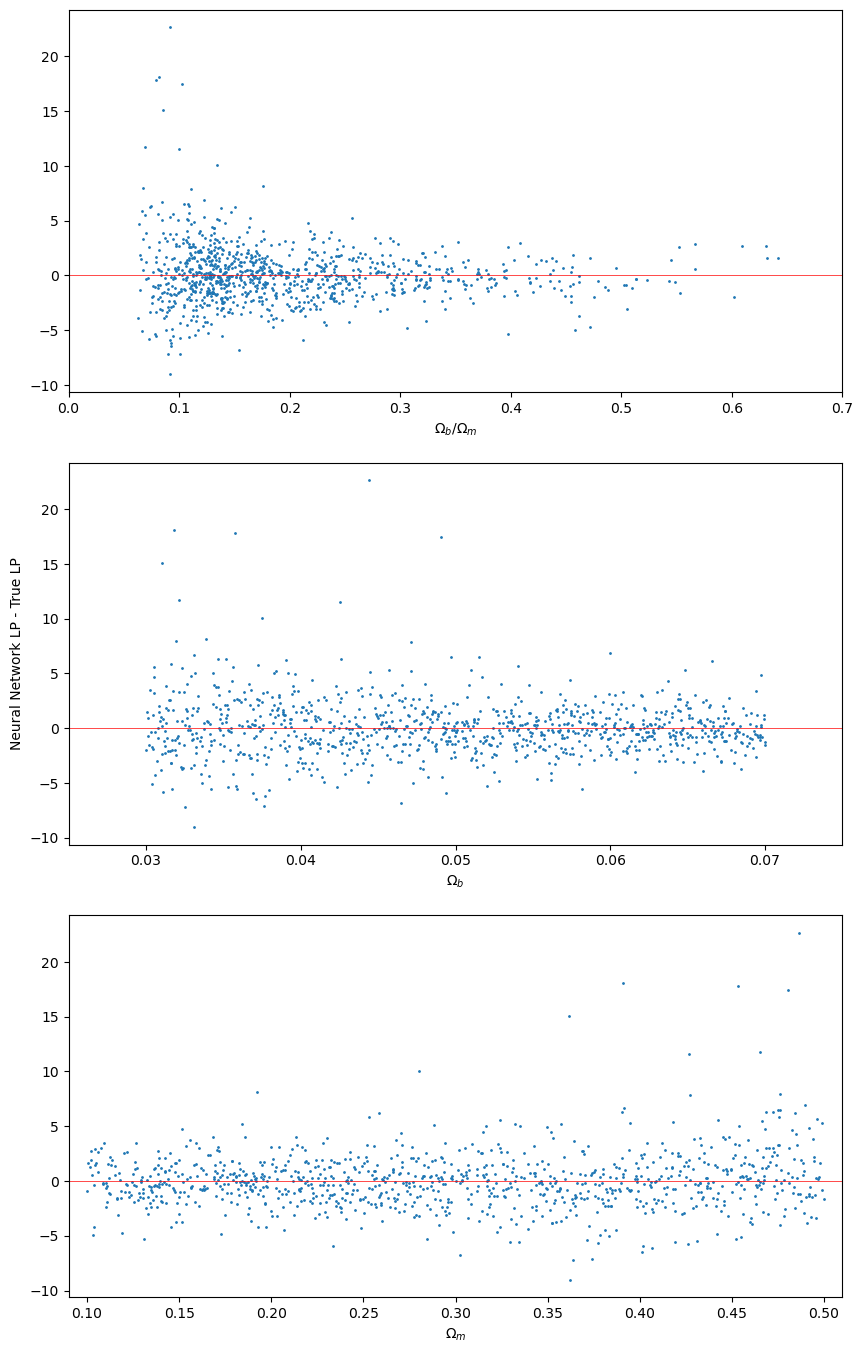

In [52]:
%matplotlib inline

fig, ax = plt.subplots(3, figsize=[9, 14], dpi=100)
fig.tight_layout(pad=3)

ax[0].hlines(y=0, xmin=0, xmax=1, lw=0.5, color='r')
ax[1].hlines(y=0, xmin=0, xmax=1, lw=0.5, color='r')
ax[2].hlines(y=0, xmin=0, xmax=1, lw=0.5, color='r')
ax[0].scatter(testOmegaB/testOmegaM, testResiduals, s=1)
ax[1].scatter(testOmegaB, testResiduals, s=1)
ax[2].scatter(testOmegaM, testResiduals, s=1)

ax[0].set_xlim(0, 0.7)
ax[1].set_xlim(0.025, 0.075)
ax[2].set_xlim(0.09, 0.51)

ax[0].set_xlabel('$\Omega_b/\Omega_m$')
ax[1].set_xlabel('$\Omega_b$')
ax[2].set_xlabel('$\Omega_m$')

p = ax[1].set_ylabel('Neural Network LP - True LP')

#### Look at outliers individually

In [77]:
def plot3(number, z3scale=1):
    linCFfile = ascii.read(f'linearCF/linearCF{number}.dat')  
    linCF = Table(linCFfile)
    
    nonLin = txt_to_table(number, 0) # z = 0
    nonLin3 = txt_to_table(number, 3) # z = 3
    
    dip, peak, lp, ip = scales(linCF)
    
    # Plotting
    fig = plt.figure(figsize=[5, 3], dpi=200)

    spl = UnivariateSpline(linCF['r'], linCF['xi'], k=4, s=0) # degree 4 spline fit

    ## Add vertical/horizontal width in plot ##
    r_min, r_max = dip - 50, peak + 50
    if spl(peak) <= 0:
        xi_max = -1*spl(peak)
    else:
        xi_max = spl(peak)*1.2
    if np.min(linCF['xi']) <= 0:
        xi_min = np.min(linCF['xi'])*1.4
    else:
        xi_min = np.min(linCF['xi'])*0.8
        

    plt.plot(linCF['r'], linCF['xi'], c='r', label='Linear z=0 CF')

    plt.vlines([dip, peak], ymin=xi_min, ymax=xi_max, color='r', lw=0.5, ls='-.', label='Dip/peak')
    plt.vlines(lp, ymin=xi_min, ymax=xi_max, color='b', lw=0.5, ls='-.', label='LP')
    plt.vlines(ip, ymin=xi_min, ymax=xi_max, color='g', lw=0.5, ls='-.', label='IP')
    plt.scatter([dip, peak, lp, ip], [spl(dip), spl(peak), spl(lp), spl(ip)], c=['r', 'r', 'b', 'g'], s=2, zorder=1000)

    plt.plot(nonLin['r'], nonLin['xi'], label='Quijote z=0 CF', lw=2, c='b')
    plt.plot(nonLin3['r'], nonLin3['xi']*z3scale, label='Quijote z=3 CF', lw = 2, c='lime')


    # figure parameters
    plt.xlim(r_min, r_max)
    plt.ylim(xi_min, xi_max)


    plt.xlabel('r  $[h^{-1}$ Mpc]', fontsize=6)
    plt.ylabel('$\\xi(r)$', fontsize=6)
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.title('Correlation Function', fontsize=8)
    p = plt.legend(fontsize=4)

/gpfs/gibbs/project/padmanabhan/ann22/conda_envs/bao/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:724: RuntimeWarning: The number of zeros exceeds mest
  warnings.warn(RuntimeWarning("The number of zeros exceeds mest"))


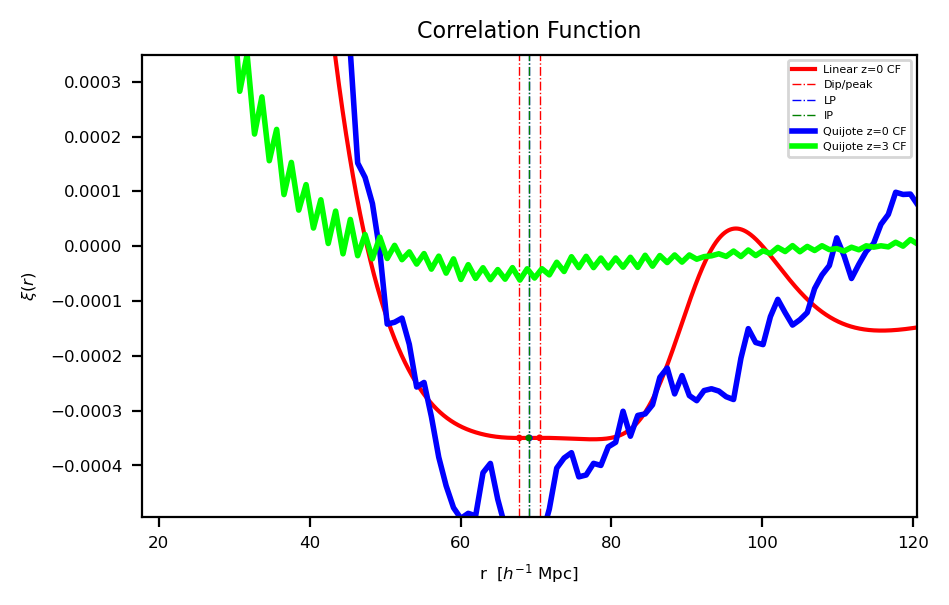

In [126]:
plot3(381, z3scale=1)

# 6. Fitting Polynomials to Quijote CFs

In [68]:
z0lpList, z3lpList, cfList = [], [], []

for x in scaleTable['CF']: # all simulations with scales
    cfList.append(x)
    nonLin0 = txt_to_table(x, 0) # z = 0
    nonLin3 = txt_to_table(x, 3) # z = 3
    
    z0lp = polyLP(nonLin0['r'], nonLin0['xi'], 60, 140, 9)
    z3lp = polyLP(nonLin3['r'], nonLin3['xi'], 60, 140, 9)
    
    
    z0lpList.append(z0lp)
    z3lpList.append(z3lp)

    
polyLPtable = Table([cfList, z0lpList, z3lpList],
                    names=('CF', 'z0PolyLP', 'z3PolyLP')) # astropy table

In [75]:
np.argmax(polyLPtable['z0PolyLP'])

1862

In [76]:
polyLPtable[1862]

CF,z0PolyLP,z3PolyLP
int64,float64,float64
1864,137.64732784479492,93.48469749306359


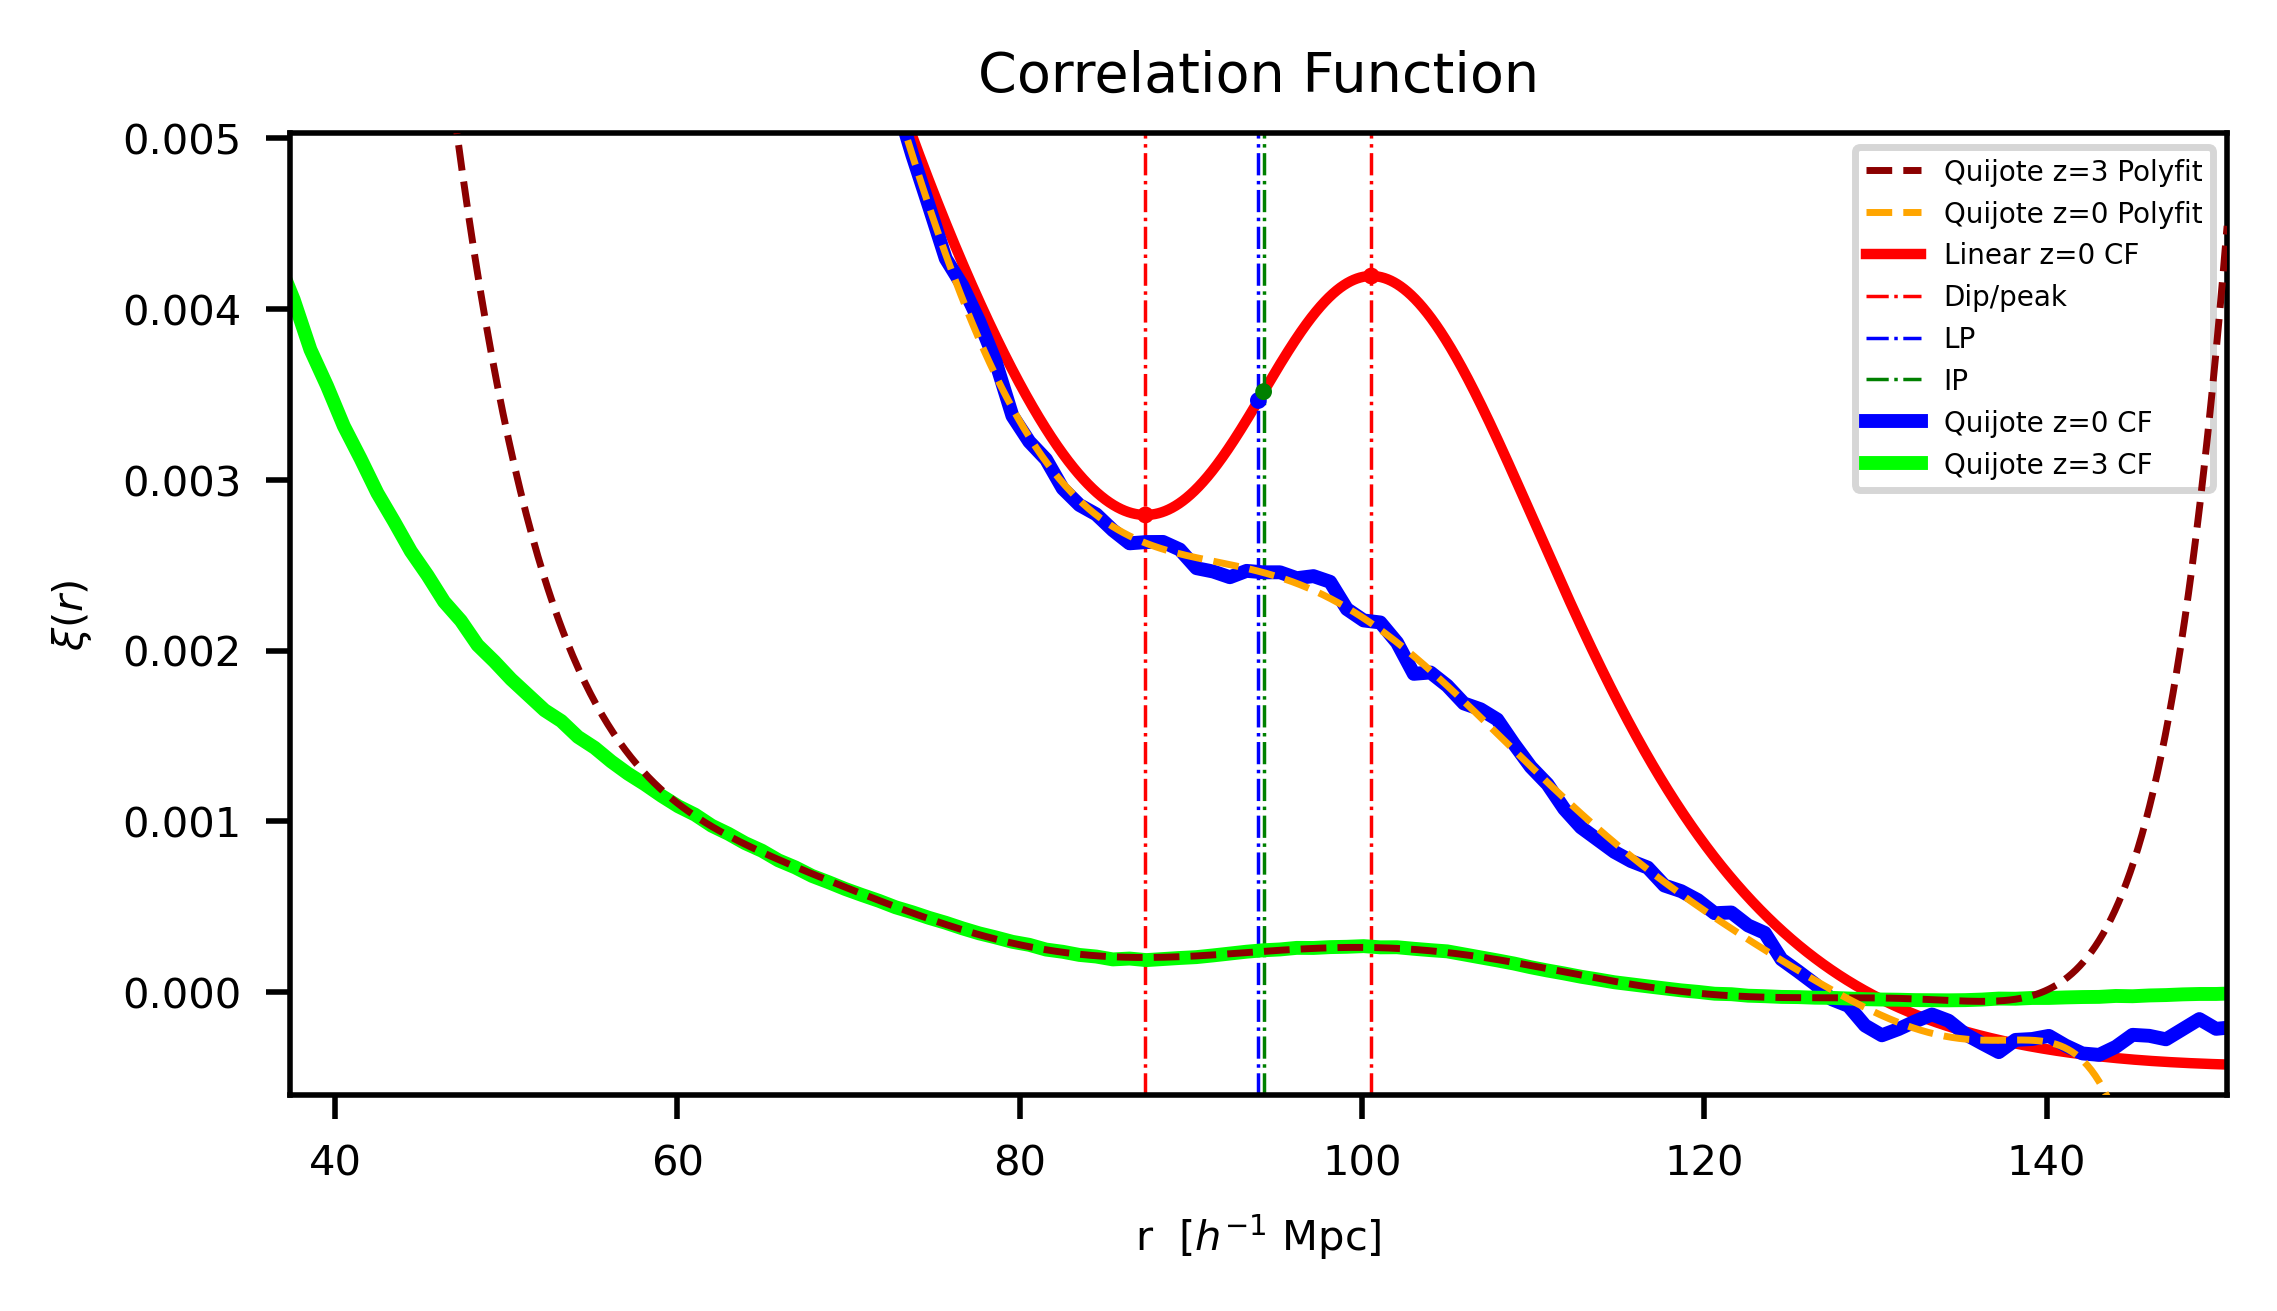

In [79]:
plot3poly(1864)

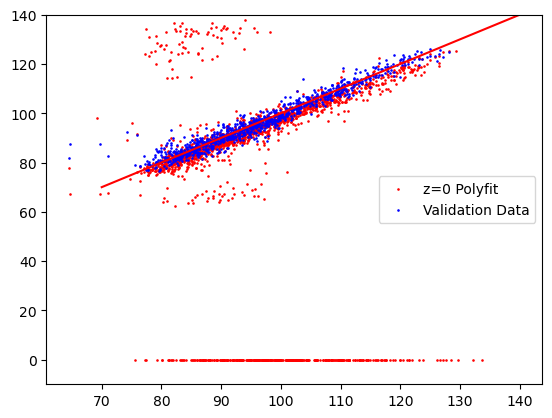

In [133]:
xxxx = np.linspace(70, 140, 1000)
plt.plot(xxxx, xxxx, c='r')
plt.scatter(lps, polyLPtable['z0PolyLP'], s=0.75, c='r', label='z=0 Polyfit')
#plt.scatter(lps, polyLPtable['z3PolyLP'], s=0.75, c='orange', label='z=3 Polyfit')
plt.scatter(lps_test, model_lps_test, c='b', s=0.75, label='Validation Data')
#plt.scatter(lps_train, model_lps_train, c='g', s=0.75, label='Training Data')

plt.ylim(-10, 140)
p = plt.legend()

# 8. Convolutional Neural Network

In [156]:
l1 = torch.nn.Conv1d(in_channels=1, out_channels=2, kernel_size=5, stride=2)
l2 = torch.nn.Conv1d(in_channels=2, out_channels=1, kernel_size=5, stride=1)
pool = torch.nn.MaxPool1d(2)

lin = torch.nn.Linear(15, 1)
criterion = nn.MSELoss()
relu = torch.nn.ReLU()

In [157]:
conv = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=1, out_channels=50, kernel_size=4, stride=1),
            torch.nn.MaxPool1d(2),
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels=50, out_channels=50, kernel_size=2, stride=2),
            torch.nn.MaxPool1d(2),
            torch.nn.ReLU())
connected = torch.nn.Sequential(
            torch.nn.Linear(200, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 1))

In [158]:
for batch_features, batch_labels in train_dataloaderShiftedErr:
    xx = conv(batch_features.unsqueeze(0))
    xxx = torch.flatten(xx)
    print(xxx.size)
    out = connected(xxx)
    print(out)
    break

<built-in method size of Tensor object at 0x2aced2774720>
tensor([0.3204], grad_fn=<AddBackward0>)


In [58]:
class cnn(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.conv = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=1, out_channels=50, kernel_size=4, stride=1),
            torch.nn.MaxPool1d(2),
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels=50, out_channels=50, kernel_size=2, stride=2),
            torch.nn.MaxPool1d(2),
            torch.nn.ReLU())
        
        self.connected = torch.nn.Sequential(
            torch.nn.Linear(200, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 1))


    def forward(self, features):
        convolved = self.conv(features.unsqueeze(0))
        linInput = torch.flatten(convolved)
        output = self.connected(linInput)
        return output

In [241]:
modelShiftedErrCNN = cnn().to(device)

In [270]:
modelShiftedErrCNN, train_lossShiftedErrCNN, test_lossShiftedErrCNN = trainBAOReconNN(modelShiftedErrCNN, train_dataloaderShiftedErr, test_dataloaderShiftedErr, lr=1e-5, epochs=50)

epoch : 1/50, train loss = 13.98932312, test loss = 17.78097989
epoch : 2/50, train loss = 13.98214005, test loss = 17.71054687
epoch : 3/50, train loss = 13.75959460, test loss = 17.55326259
epoch : 4/50, train loss = 13.65310171, test loss = 17.53567804
epoch : 5/50, train loss = 13.70035168, test loss = 17.60683374
epoch : 6/50, train loss = 13.61743754, test loss = 17.54884953
epoch : 7/50, train loss = 14.93207993, test loss = 18.93010976
epoch : 8/50, train loss = 14.69836181, test loss = 18.56938269
epoch : 9/50, train loss = 13.63994225, test loss = 17.62105287
epoch : 10/50, train loss = 13.60663606, test loss = 17.35831527
epoch : 11/50, train loss = 13.58764598, test loss = 17.37642754
epoch : 12/50, train loss = 13.65352676, test loss = 17.65995698
epoch : 13/50, train loss = 14.39213702, test loss = 18.26397904
epoch : 14/50, train loss = 13.59174585, test loss = 17.61704618
epoch : 15/50, train loss = 13.43665904, test loss = 17.30600705
epoch : 16/50, train loss = 13.544

In [271]:
model_lpsShiftedErrCNN = []
for i in renormShiftedErrInputs_xi:
    #normalized_inputs = (np.copy(i) - mean_inputs_norm)/var_inputs_norm  
    model_lp = modelShiftedErrCNN(torch.Tensor(i).unsqueeze(0)).item()*var_lps+mean_lps
    model_lpsShiftedErrCNN.append(model_lp)

model_lpsShiftedErrCNN = np.array(model_lpsShiftedErrCNN)

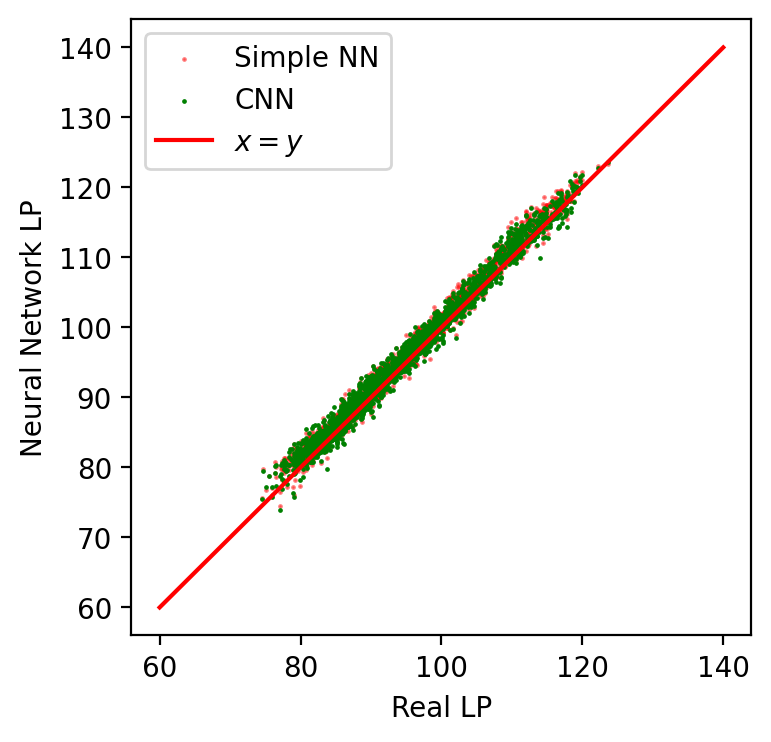

In [272]:
fig = plt.figure(figsize=[4,4], dpi=200)
lineX = np.linspace(60, 140, 100)
plt.scatter(lpDist, model_lpsShiftedErr, c='r', s=0.5, label='Simple NN', alpha=0.5)
plt.scatter(lpDist, model_lpsShiftedErrCNN, c='g', s=0.5, label='CNN')




plt.plot(lineX, lineX, c='r', label='$x=y$')

plt.xlabel('Real LP')
plt.ylabel('Neural Network LP')
p = plt.legend()

In [273]:
# run this cell to save the model
torch.save(modelShiftedErrCNN.state_dict(), 'scaleNNmodels/modelShiftedErrCNN.pth')

In [274]:
# run this cell to load the saved model
modelShiftedErrCNN = cnn().to(device)
modelShiftedErrCNN.load_state_dict(torch.load('scaleNNmodels/modelShiftedErrCNN.pth'))
modelShiftedErrCNN.eval()

cnn(
  (conv): Sequential(
    (0): Conv1d(1, 50, kernel_size=(4,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv1d(50, 50, kernel_size=(2,), stride=(2,))
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (connected): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [275]:
model_lpsShiftedErrCNN2 = []
for i in renormShiftedErrInputs_xi2:
    #normalized_inputs = (np.copy(i) - mean_inputs_norm)/var_inputs_norm  
    model_lp = modelShiftedErrCNN(torch.Tensor(i)).item()*var_lps+mean_lps
    model_lpsShiftedErrCNN2.append(model_lp)

model_lpsShiftedErrCNN2 = np.array(model_lpsShiftedErrCNN2)

In [279]:
renormShiftedErrInputs_xi2

array([[ 1.00000000e+00,  8.15197509e-01,  6.55952247e-01, ...,
        -4.62179410e-02, -5.09577829e-02, -5.33490845e-02],
       [ 1.00000000e+00,  3.10401969e-01,  2.63147172e-01, ...,
        -7.56605372e-03, -5.78299135e-03, -6.06349556e-03],
       [ 1.00000000e+00,  5.42716126e-01,  6.11240077e-01, ...,
        -5.32298668e-02, -4.98302998e-02, -4.58050254e-02],
       ...,
       [ 1.00000000e+00,  7.99303768e-01,  4.70549368e-01, ...,
         5.31535448e-03,  4.46338399e-03,  4.52666731e-03],
       [ 1.00000000e+00,  1.39012967e+00,  1.73830765e+00, ...,
        -3.17837271e-02, -1.96609725e-02, -3.48140067e-02],
       [ 1.00000000e+00,  9.32872944e-01,  8.63200504e-01, ...,
         1.98842318e-03,  1.59102522e-03,  8.82456003e-04]])

In [280]:
polyCNN = []

for x in renormShiftedErrInputs_xi2: # all simulations with scales    
    lp = polyLP(inputs_r[0], x, 60, 140, 9)
    
    polyCNN.append(lp)

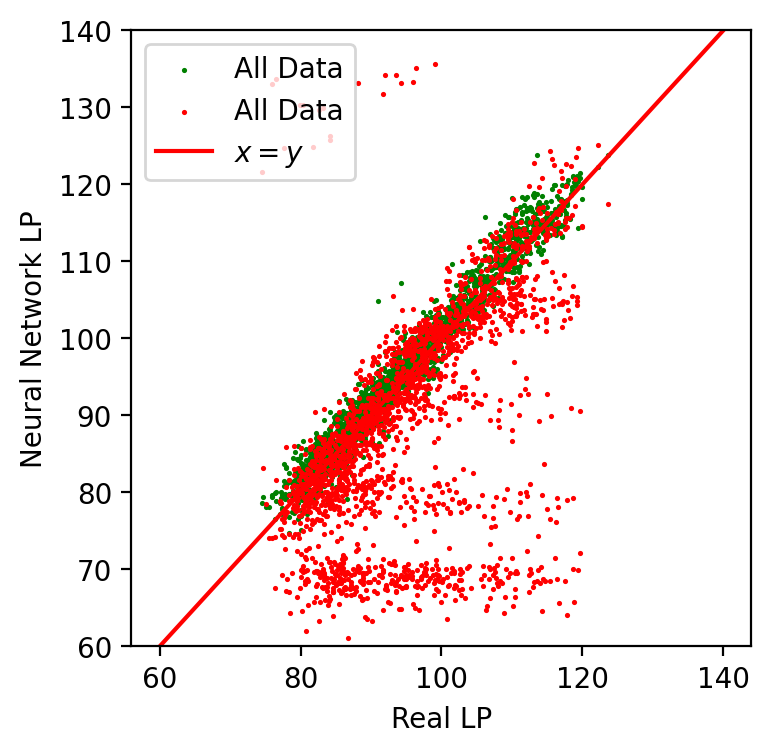

In [284]:
fig = plt.figure(figsize=[4,4], dpi=200)
lineX = np.linspace(60, 140, 100)
plt.scatter(lpDist, model_lpsShiftedErrCNN2, c='g', s=0.75, label='All Data')
#plt.scatter(lpDist, model_lpsShiftedErr2, c='b', s=0.75, label='All Data')
plt.scatter(lpDist, polyCNN, c='r', s=0.75, label='All Data')


plt.plot(lineX, lineX, c='r', label='$x=y$')

plt.xlabel('Real LP')
plt.ylabel('Neural Network LP')
plt.ylim(60, 140)
p = plt.legend()

# 10. Abacus Cosmology

In [46]:
def cosmol(omega_cdm, omega_b, h, n_s, sigma_8, k_max = 1e3, zmax=100.):
    # set cosmological parameters
    H0 = h*100
    params = {'output' : 'mPk',
             'omega_b' : omega_b,
             'omega_cdm' : omega_cdm,
             'H0' : H0,
             'n_s' : n_s,
             'sigma8' : sigma_8,
             'P_k_max_1/Mpc' : k_max,
             'z_max_pk' : zmax}
    
    # compute cosmology
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    
    return cosmo

In [47]:
abacusH = 0.6736
abacusOmegaCDM = 0.12
abacusOmegaB = 0.02237
abacusNS = 0.9649
abacusS8 = 0.811355

k_min = 1e-5
k_max = 1e3

In [52]:
abacusCosmo = cosmol(abacusOmegaCDM, abacusOmegaB, abacusH, abacusNS, abacusS8)

In [53]:
abacusCF = corr(abacusCosmo, k_min, k_max)

In [54]:
dipAbacus, peakAbacus, lpAbacus, ipAbacus = scales(abacusCF)

In [55]:
lpAbacus

92.99391773745307

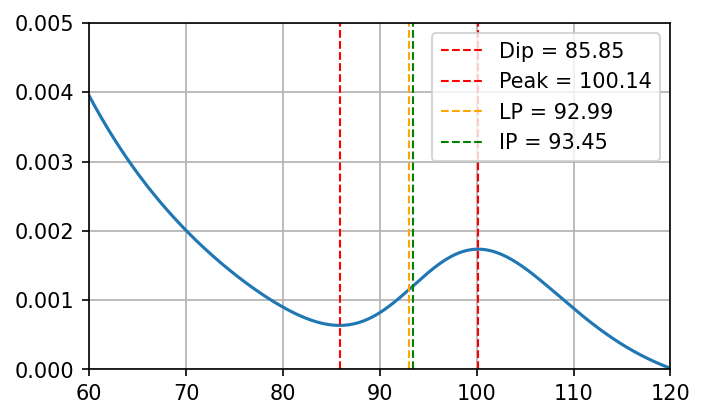

In [56]:
plt.figure(figsize=[5, 3], dpi=150)

plt.plot(abacusCF['r'], abacusCF['xi'])
plt.vlines(dipAbacus, ymin=0, ymax=0.01, color='r', ls='--', lw=1, label=f'Dip = {dipAbacus:0.2f}')
plt.vlines(peakAbacus, ymin=0, ymax=0.01, color='r', ls='--', lw=1, label=f'Peak = {peakAbacus:0.2f}')
plt.vlines(lpAbacus, ymin=0, ymax=0.01, color='orange', ls='--', lw=1, label=f'LP = {lpAbacus:0.2f}')
plt.vlines(ipAbacus, ymin=0, ymax=0.01, color='g', ls='--', lw=1, label=f'IP = {ipAbacus:0.2f}')


plt.legend()
plt.xlim(60, 120)
plt.ylim(0, 0.005)
plt.grid()